In [ ]:
import json
import string
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
import re
import nltk
import pip
from nltk import collections
from nltk.tag import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm, metrics
from sklearn.metrics import precision_recall_fscore_support
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# clean data
default_stopwords = set(nltk.corpus.stopwords.words('english'))
# will have to add the following custom
custom_stopwords = {"http://", "rt", "co", "https://", "www", "@", "ha", "wa", "covid-19", "covid", "coronavirus"}
all_stopwords = default_stopwords | custom_stopwords
eng_stemmer = nltk.stem.SnowballStemmer('english')
tt = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

def clean_data(text):
    # print("Started preprocessing!")
    # text = df['reply_text'].apply(str)
    text = re.sub(r'((www\.[^\s]+)|(https?://[^\s]+))', '', text)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#[^\s]+', '', text)
    text = tt.tokenize(text)
    # remove single character words
    text = [word for word in text if len(word) > 2]
    # convert to lower case
    text = [word.lower() for word in text]
    # removing numbers
    # text = [word for word in text if not word.isnumeric()]
    text = [word for word in text if word.isalpha()]
    # stem the words
    text = [lemmatizer.lemmatize(word) for word in text]
    # remove stopwords
    text = [word for word in text if nltk.re.match(r".*[a-z]+.*", word)]
    text = [word for word in text if word not in all_stopwords]
    text = " ".join(text)
    return text


def process_json_data(read_data_filepath, label, senti):
  with open(read_data_filepath, 'r') as f:
    source_id = []
    source_text = []
    reply_text = []
    total_text = []
    tweet_time = []
    retweet_count = []
    for line in f:
      line = json.loads(line)
      source_id.append(line[0]['id_str'])
      tweet_time.append(convert(line[0]["created_at"]))
      retweet_count.append(line[0]["retweet_count"]+1)
      tmp0 = []
      for tweet in line:
        tmp0.append(tweet['text'])
      total_text.append(tmp0)
      source_text.append(clean_data(line[0]['text']))
      tmp = []
      for i in range(1, len(line)):
        tmp.append(clean_data(line[i]['text']))
      reply_text.append(tmp)
    df_data = pd.DataFrame({'id':source_id, 'time': tweet_time, 'retweet_count':retweet_count, 'source_text':source_text, 'reply_text':reply_text, 'total_text':total_text, 'label':label, 'senti':senti})
    return df_data[['id', 'time', 'retweet_count', 'source_text', 'reply_text', 'total_text', 'label', 'senti']]
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from datetime import datetime
def convert(time):
  time = datetime.strptime(time,'%a %b %d %H:%M:%S %z %Y');
  return time.strftime('%Y-%m-%d')

In [ ]:
# get label data
# open txt file
file_object = open('/content/drive/My Drive/data/covid-label.txt')
try:
    file_content = file_object.read()
finally:
    file_object.close()
# split by ",""
result = file_content.split(',')

label = []
for i in result:
   label.append(i)

label = list(map(int, label))

# get senti data
df_senti = pd.DataFrame(pd.read_csv('/content/drive/My Drive/data/source_senti.csv', header=0))
senti = df_senti.senti.tolist()

In [ ]:
df_covid = process_json_data('/content/drive/My Drive/data/covid.data.jsonl', label, senti)
df_covid["time"] = pd.to_datetime(df_covid["time"])

# a list of events, and each event is a list of tweets (source tweet + reactions)
print("Number of test data =", len(df_covid["source_text"]))

Number of test data = 17458


In [ ]:
df_rumour = df_covid.loc[df_covid['label'] == 1]
df_non_rumour = df_covid.loc[df_covid['label'] == 0]

In [ ]:
# df_covid["source_text"]
# df_covid["source_text"].to_csv('source.csv')

# with open('source.json', 'w') as f:
#     json.dump(df_covid["source_text"].tolist(), f)
# import csv
# with open('source.json','r',encoding="utf-8") as file:
#     data = json.load(file)

Text(0, 0.5, 'Rumour: Number of Tweets and Retweets')

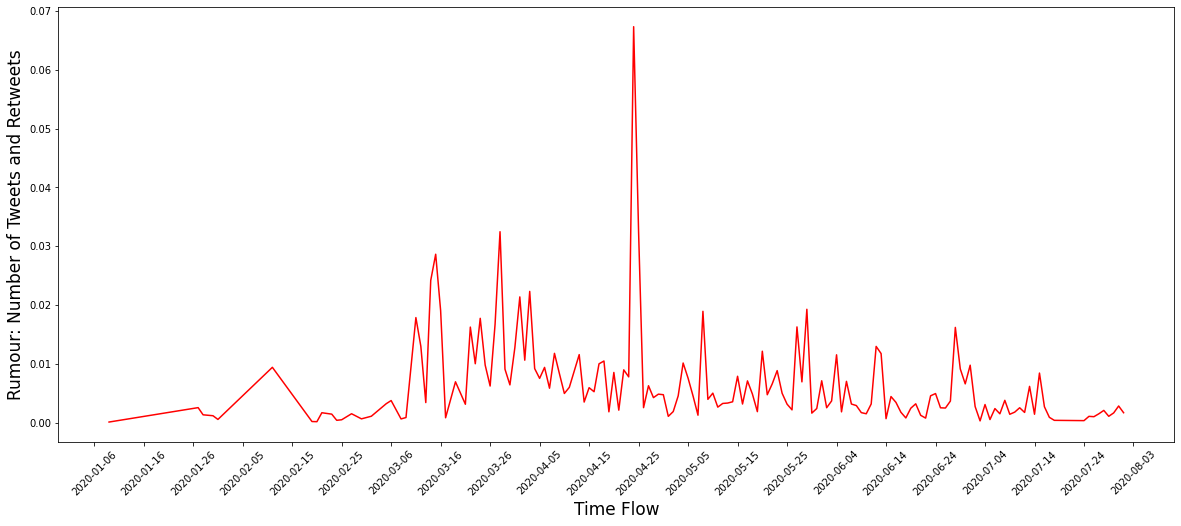

In [ ]:
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

"""
Rumour retweet based on Date change
"""
df = pd.DataFrame(df_rumour[["time", "retweet_count"]])
df = df.groupby(['time'])['retweet_count'].sum().reset_index()
df['retweet_count'] = df['retweet_count'].apply(int) / df['retweet_count'].apply(int).sum()

# def plot_line_chart(data, x, y):
ticker_spacing = df.time
ticker_spacing = 10
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.plot(df.time,df.retweet_count, 'r')
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Time Flow',fontsize=17)
plt.ylabel('Rumour: Number of Tweets and Retweets',fontsize=17)

Text(0, 0.5, 'Non-rumour: Number of Tweets and Retweets')

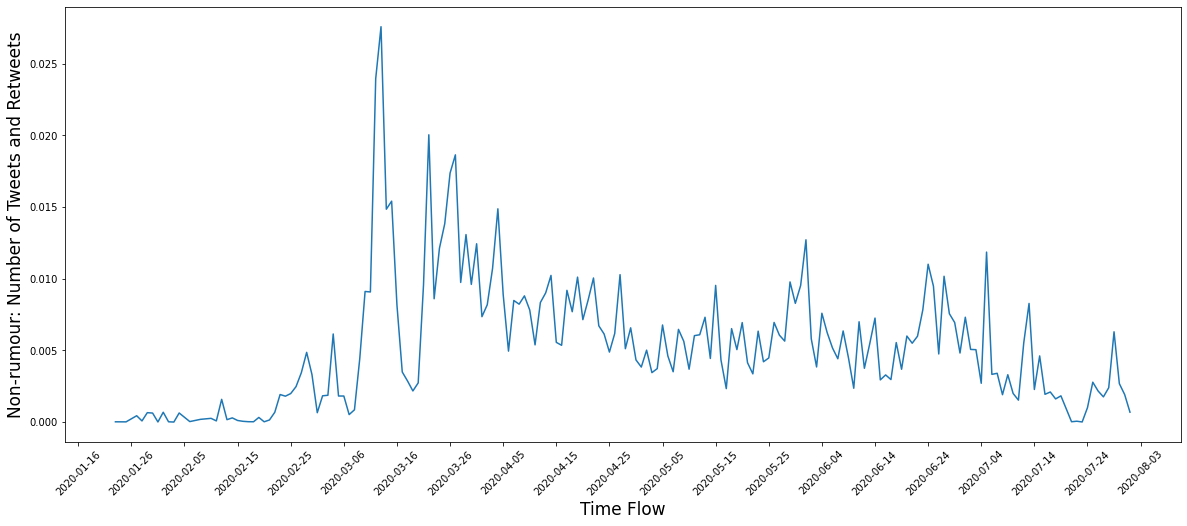

In [ ]:
"""
Non-rumour retweet based on Date change
"""

df1 = pd.DataFrame(df_non_rumour[["time", "retweet_count"]])
df1 = df1.groupby(['time'])['retweet_count'].sum().reset_index()
df1['retweet_count'] = df1['retweet_count'].apply(int) / df1['retweet_count'].apply(int).sum()

# plot non-rumour
ticker_spacing = df1.time
ticker_spacing = 10
fig, ax = plt.subplots(1,1, figsize=(20,8))
ax.plot(df1.time,df1.retweet_count)
ax.xaxis.set_major_locator(ticker.MultipleLocator(ticker_spacing))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Time Flow',fontsize=17)
plt.ylabel('Non-rumour: Number of Tweets and Retweets',fontsize=17)

In [ ]:
rumour_source = df_rumour.source_text.tolist()
non_rumour_source = df_non_rumour.source_text.tolist()
rumour_reply = df_rumour.source_text.tolist()
non_rumour_reply = df_non_rumour.source_text.tolist()
# rumour_source = " ".join(rumour_source)

In [ ]:
pd.set_option('display.max_colwidth', -1)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from wordcloud import WordCloud
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
from PIL import Image
import PIL.ImageOps
from wordcloud import ImageColorGenerator
import numpy as np
import matplotlib as mpl
from matplotlib.patches import BoxStyle
import datetime

STOPWORDS = set(stopwords.words('english'))

# dict_term_count = bow_rumour, non_rumour
def get_term_frquency_scaled(dict_term_count):
    max_tf = max(dict_term_count.values())
    dict_tf_scaled = {}
    for word, count in dict_term_count.items():
        dict_tf_scaled[word] = count/max_tf
    sorted_dict_term_count = dict(sorted(dict_tf_scaled.items(), key=lambda kv: kv[1], reverse=True))
    return sorted_dict_term_count


def generate_word_cloud(mask_image, dict_term_freq, xpos, ypos, font_size, custom_text):
    ## you need to set the terms list
    image_mask = np.array(Image.open(mask_image))
    image_colors = ImageColorGenerator(image_mask)

    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(width = 2000, height = 1200, max_words = 500, normalize_plurals = True, mask=image_mask,
                          background_color ='black', font_step = 1, relative_scaling = 0.5, collocations = False, 
                           stopwords = stopwords).generate_from_frequencies(dict_term_freq)
                       
    plt.figure(figsize = (80, 50), facecolor = None)
    plt.style.use('dark_background')
    plt.imshow(wordcloud.recolor(color_func=image_colors))
    plt.text(xpos, ypos, custom_text, fontsize=font_size)
    plt.axis("off")
    plt.show()


def plot_line_chart(data, x, y):
  plt.close("all")
  plt.style.use('default')
  import seaborn as sns
  plt.figure(figsize=(30,10))
  sns.set_style("whitegrid")
  sns.lineplot(data=data, palette="tab10", linewidth=2.5, x=x, y=y, sort= False, color="purple")
  plt.xticks(rotation=45, fontsize=20)
  plt.yticks(fontsize=20)
  plt.xlabel('Scaled Term Frequency',fontsize=20)
  plt.ylabel('Top 20 Frequent Terms',fontsize=20)
  plt.text(10, 1, custom_text, fontsize=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
def get_BOW(text):
  BOW = {}
  for word in text:
    BOW[word] = BOW.get(word, 0) + 1
  return BOW


def process_data(data):
  tmp = str()
  for i in range(len(data)):
    # for j in range(len(data[i])):
    tmp += (data[i] + " ")
  data = [tmp]
  for i in range(len(data)):
    data[i] = tt.tokenize(data[i])
    data[i] = get_BOW(data[i])
  # for i in range()
  return data

In [ ]:
[uni_rumour] = process_data(rumour_source)
[uni_non_rumour] = process_data(non_rumour_source)
sorted_uni_rumour = dict(sorted(uni_rumour.items(), key = lambda kv:(kv[1], kv[0]), reverse = True))
sorted_uni_non_rumour = dict(sorted(uni_non_rumour.items(), key = lambda kv:(kv[1], kv[0]), reverse = True))

In [ ]:
type(sorted_uni_non_rumour)

dict

scaled_freq  original_freq
term                                 
case       1.000000     719          
new        0.699583     503          
death      0.680111     489          
confirmed  0.322670     232          
report     0.289291     208          
total      0.267038     192          
day        0.262865     189          
breaking   0.253129     182          
patient    0.250348     180          
reported   0.244784     176          
number     0.230876     166          
say        0.222531     160          
people     0.211405     152          
state      0.205841     148          
died       0.168289     121          
health     0.164117     118          
hospital   0.162726     117          
positive   0.158554     114          
today      0.157163     113          
test       0.147427     106

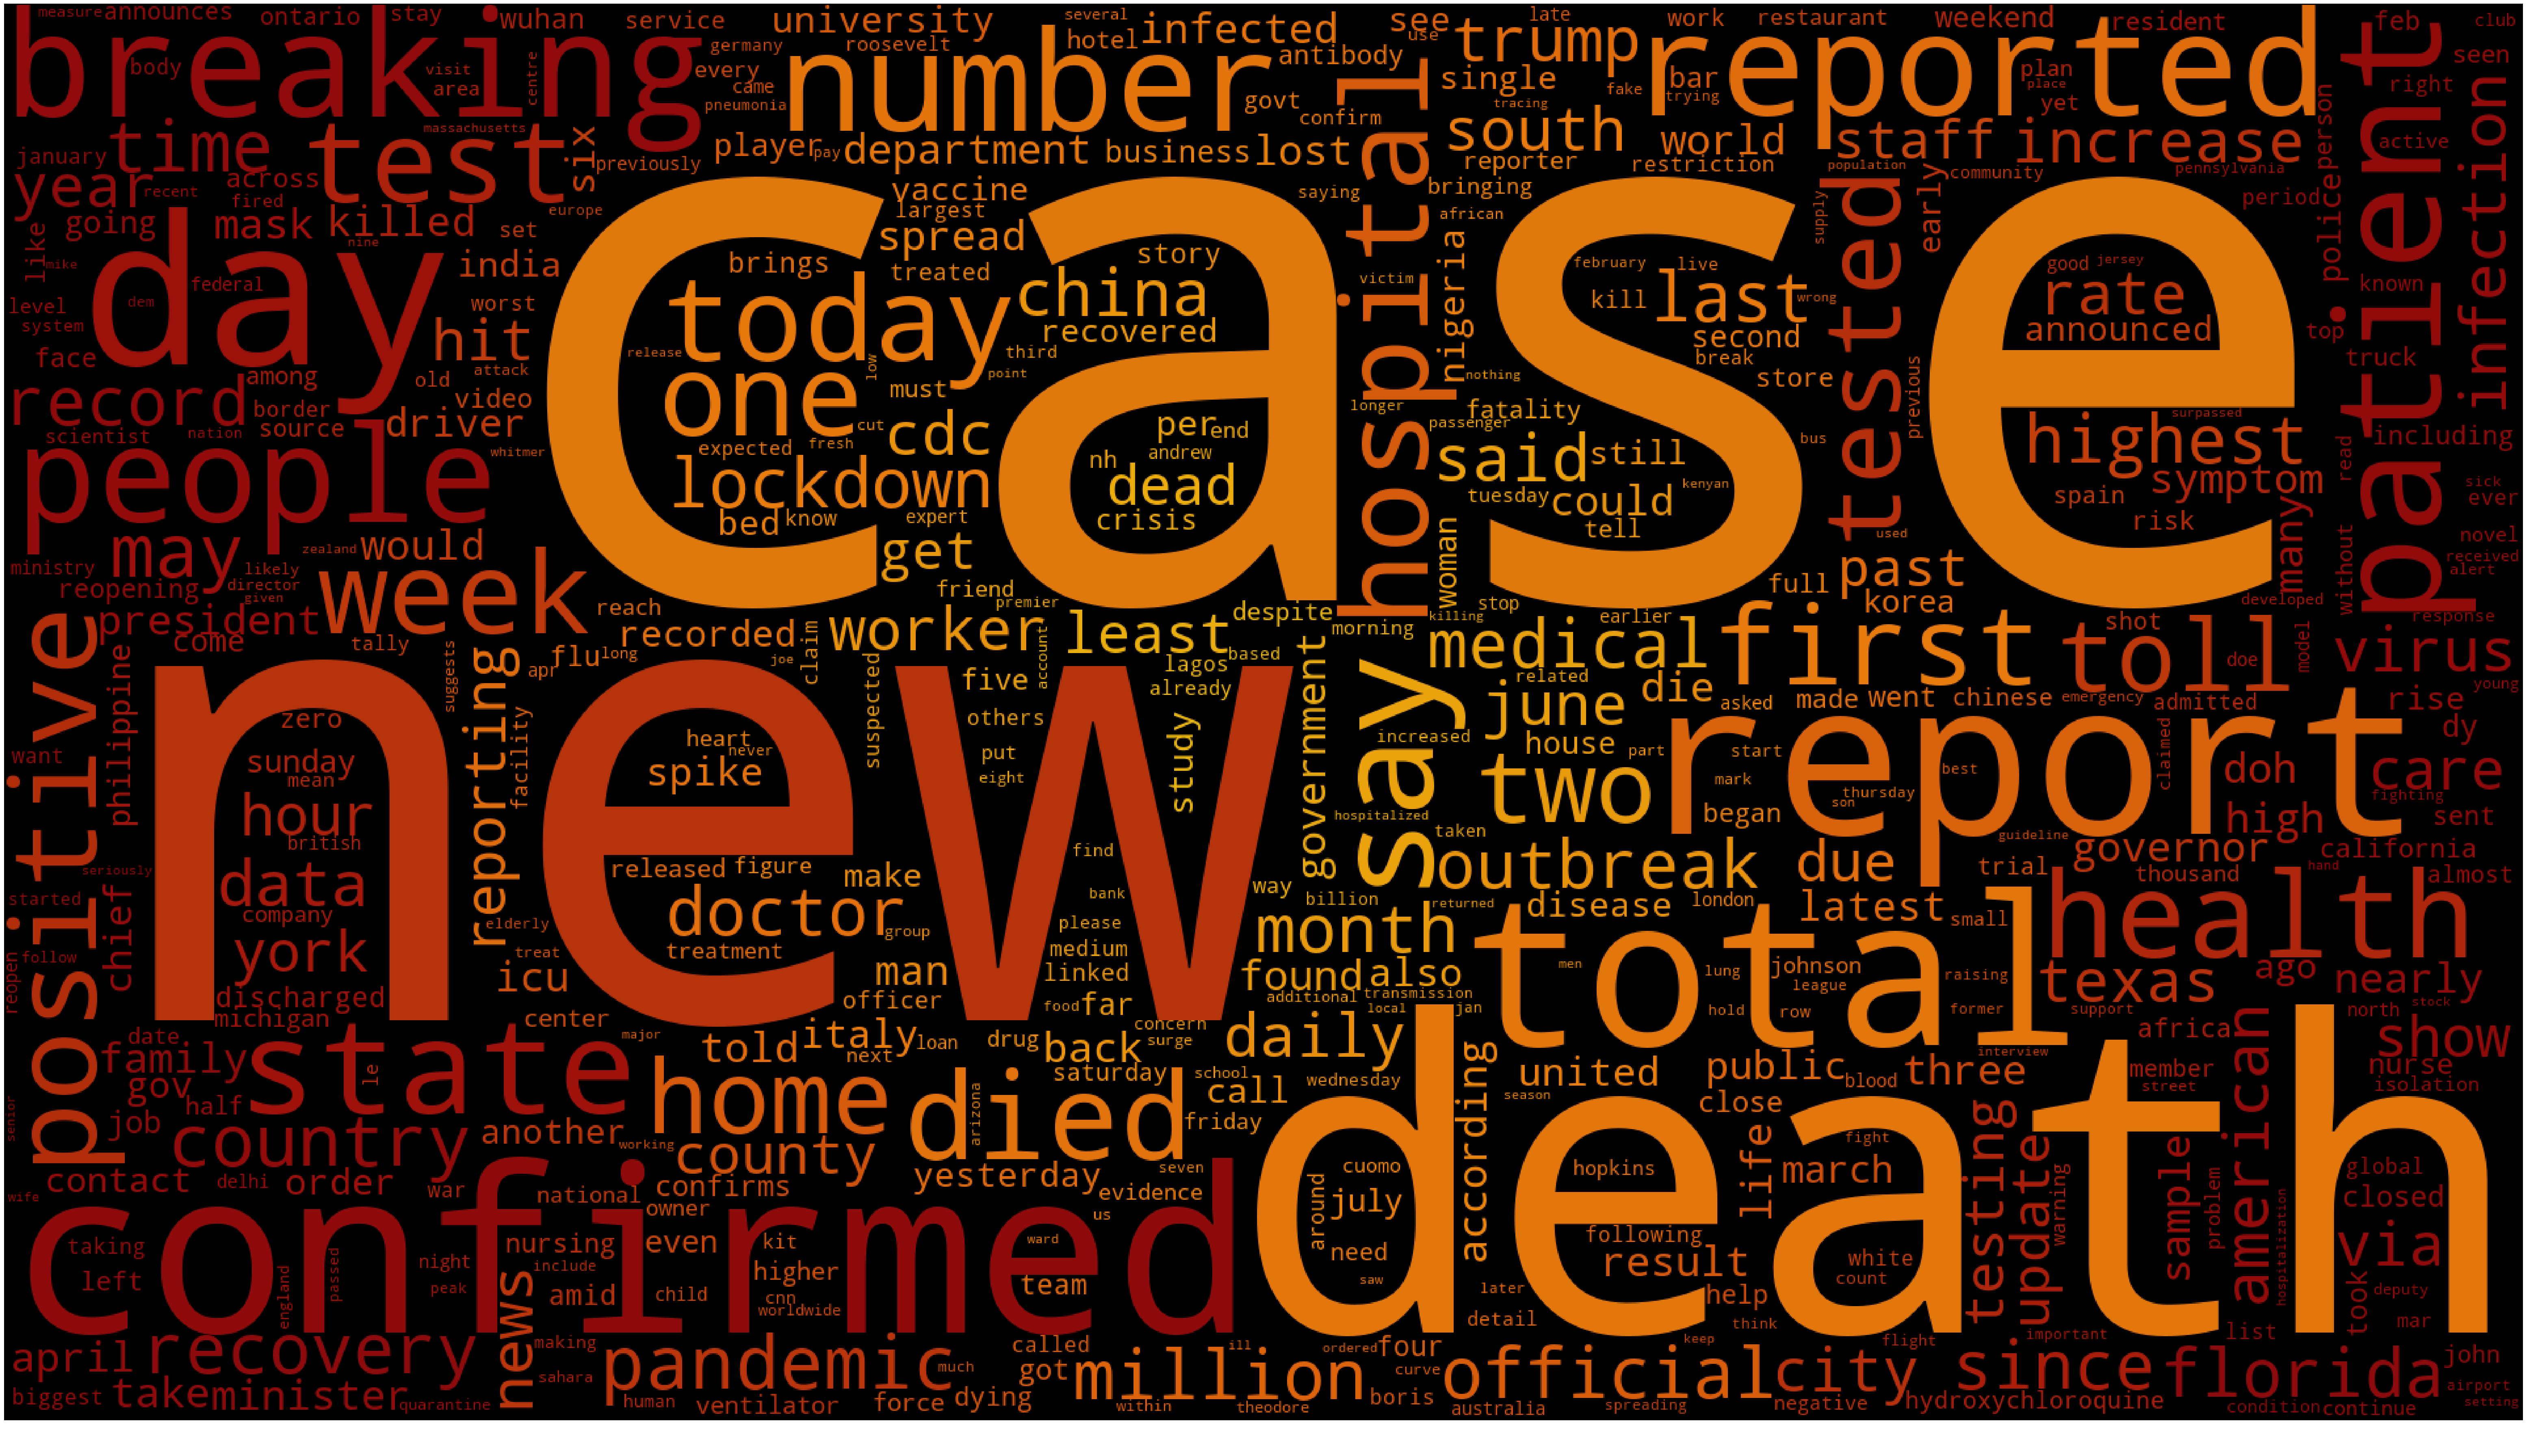

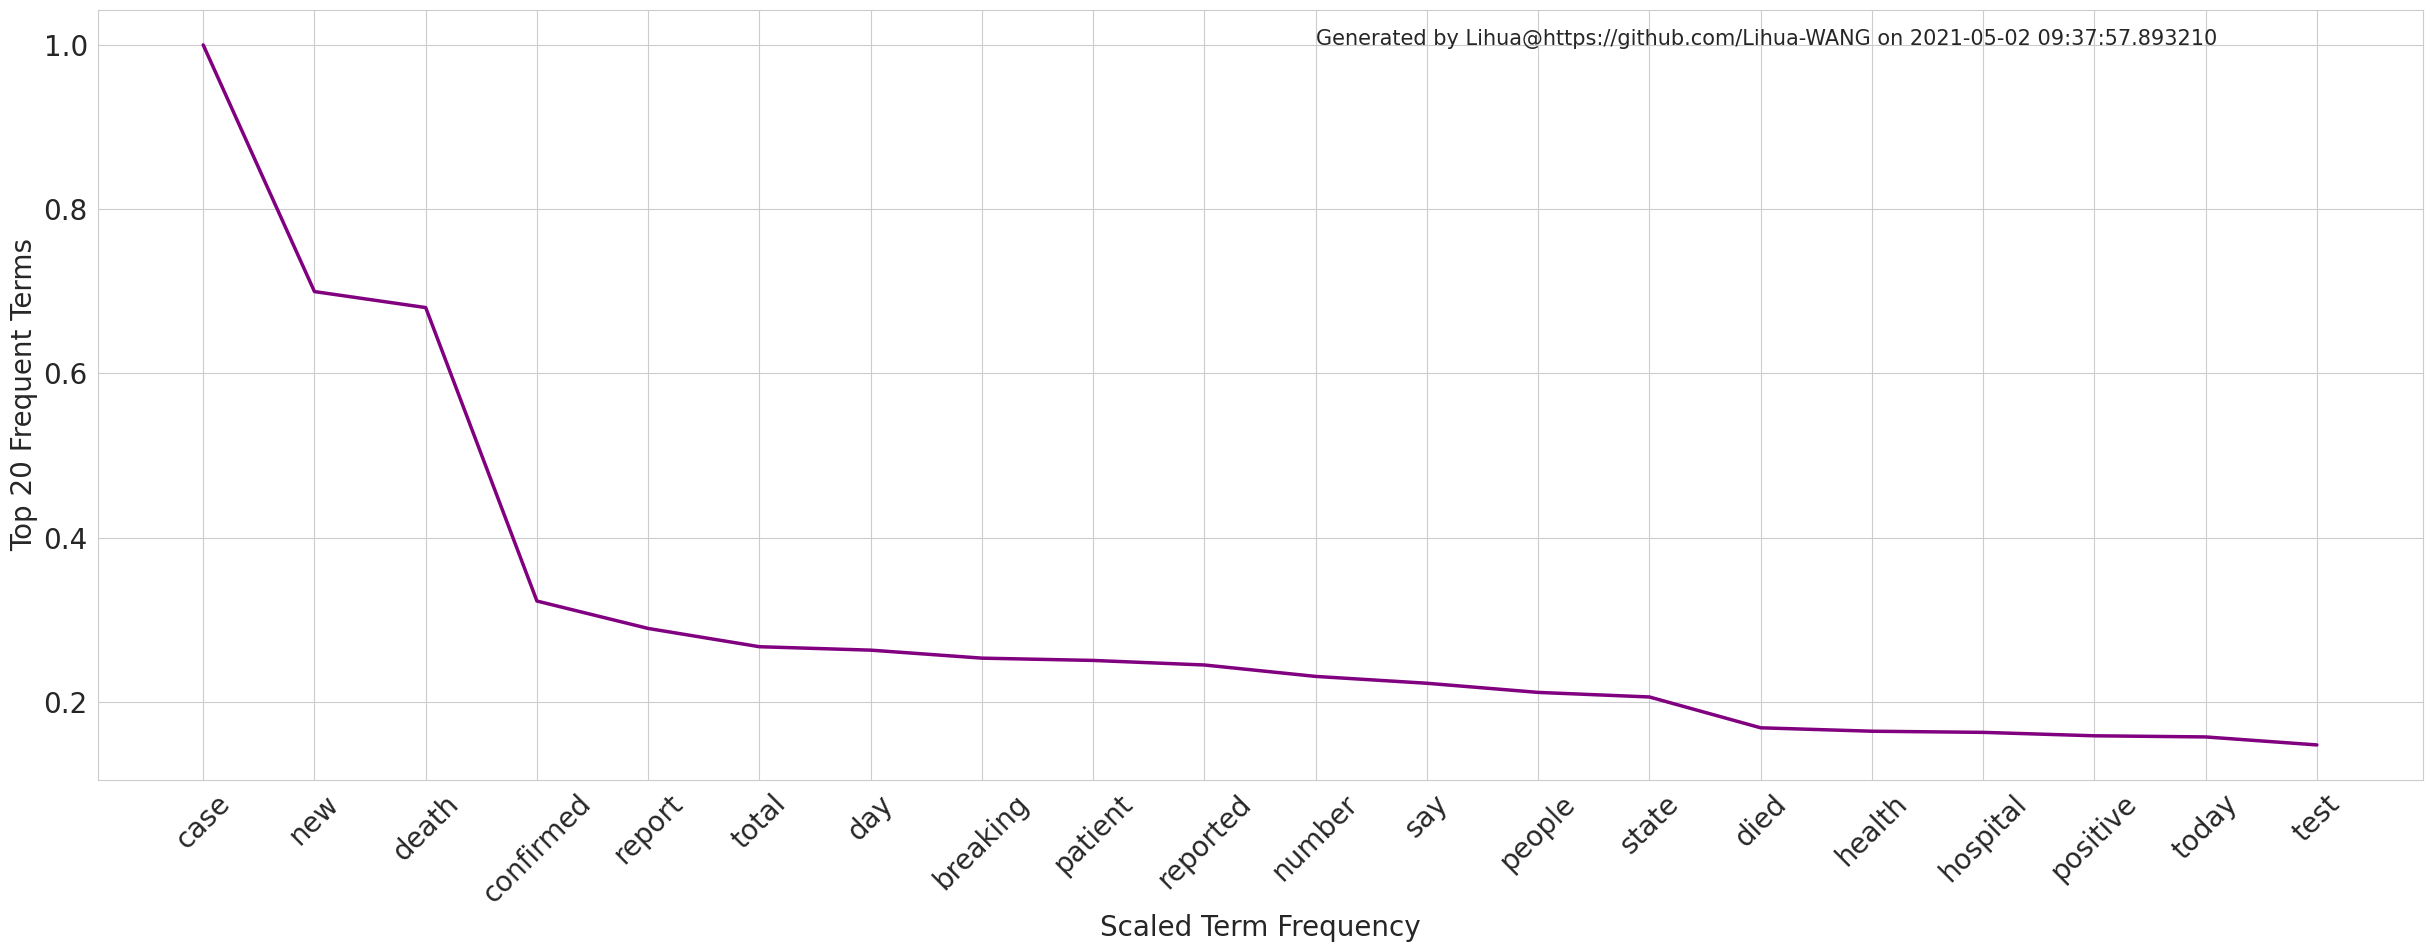

In [ ]:
# rumour
uni_rumour_tf_df = pd.DataFrame(get_term_frquency_scaled(sorted_uni_rumour).items())
uni_rumour_tf_df = uni_rumour_tf_df[:20]
uni_rumour_tf_df.columns = ['term', 'scaled_freq']
uni_rumour_tf_df.set_index('term', inplace=True)
dict_term_freq = {}
dict_term_freq['Ind_1'] = uni_rumour_tf_df
uni_rumour_tf_df['original_freq'] = list(sorted_uni_rumour.values())[:20]
display(uni_rumour_tf_df)

# wordcloud
sorted_dict_term_count = get_term_frquency_scaled(sorted_uni_rumour)
custom_text = "Generated by Lihua@https://github.com/Lihua-WANG on " + str(datetime.datetime.now())
generate_word_cloud('/content/drive/My Drive/data/red_yellow_mask3.jpg', sorted_dict_term_count, 550, 1100, 40, custom_text)
# plot
plot_line_chart(uni_rumour_tf_df, uni_rumour_tf_df.index, 'scaled_freq')

scaled_freq  original_freq
term                                 
trump      1.000000     2175         
people     0.789425     1717         
new        0.699310     1521         
case       0.660690     1437         
say        0.647356     1408         
pandemic   0.598161     1301         
death      0.521379     1134         
president  0.520920     1133         
state      0.513103     1116         
day        0.462069     1005         
one        0.425747     926          
health     0.425747     926          
test       0.381149     829          
time       0.371954     809          
american   0.370115     805          
positive   0.366897     798          
country    0.349425     760          
today      0.342989     746          
virus      0.339310     738          
mask       0.337931     735

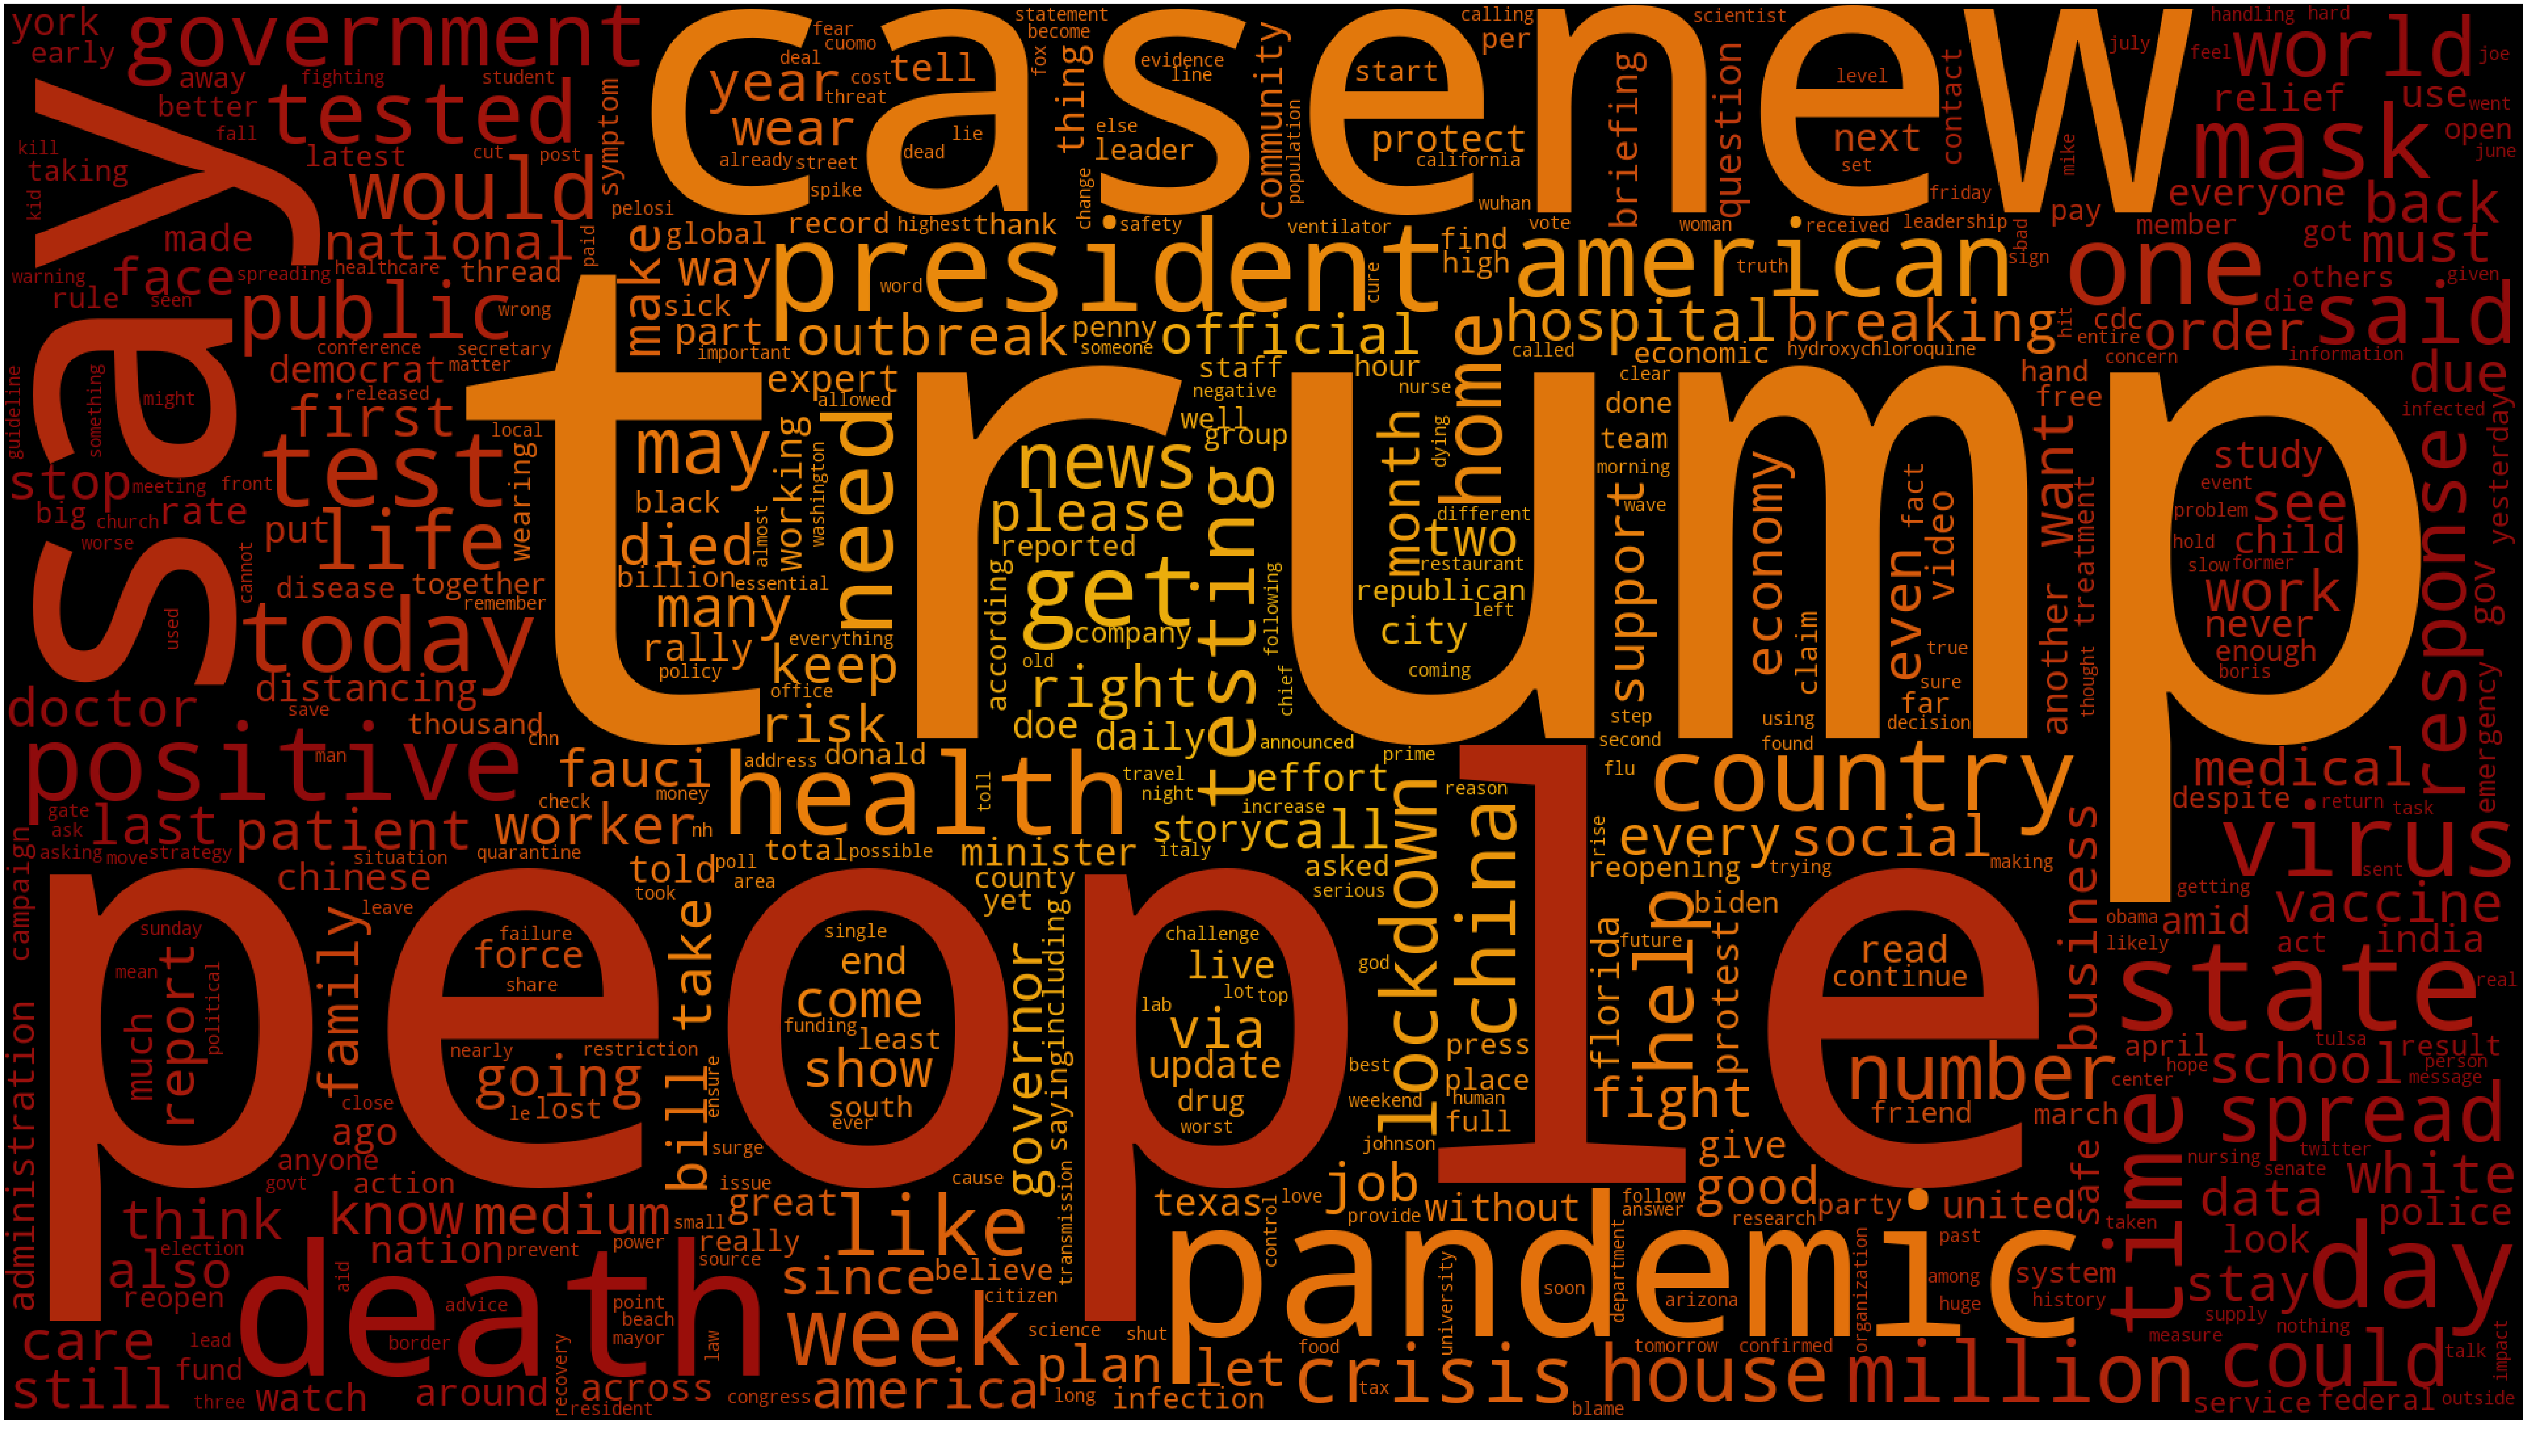

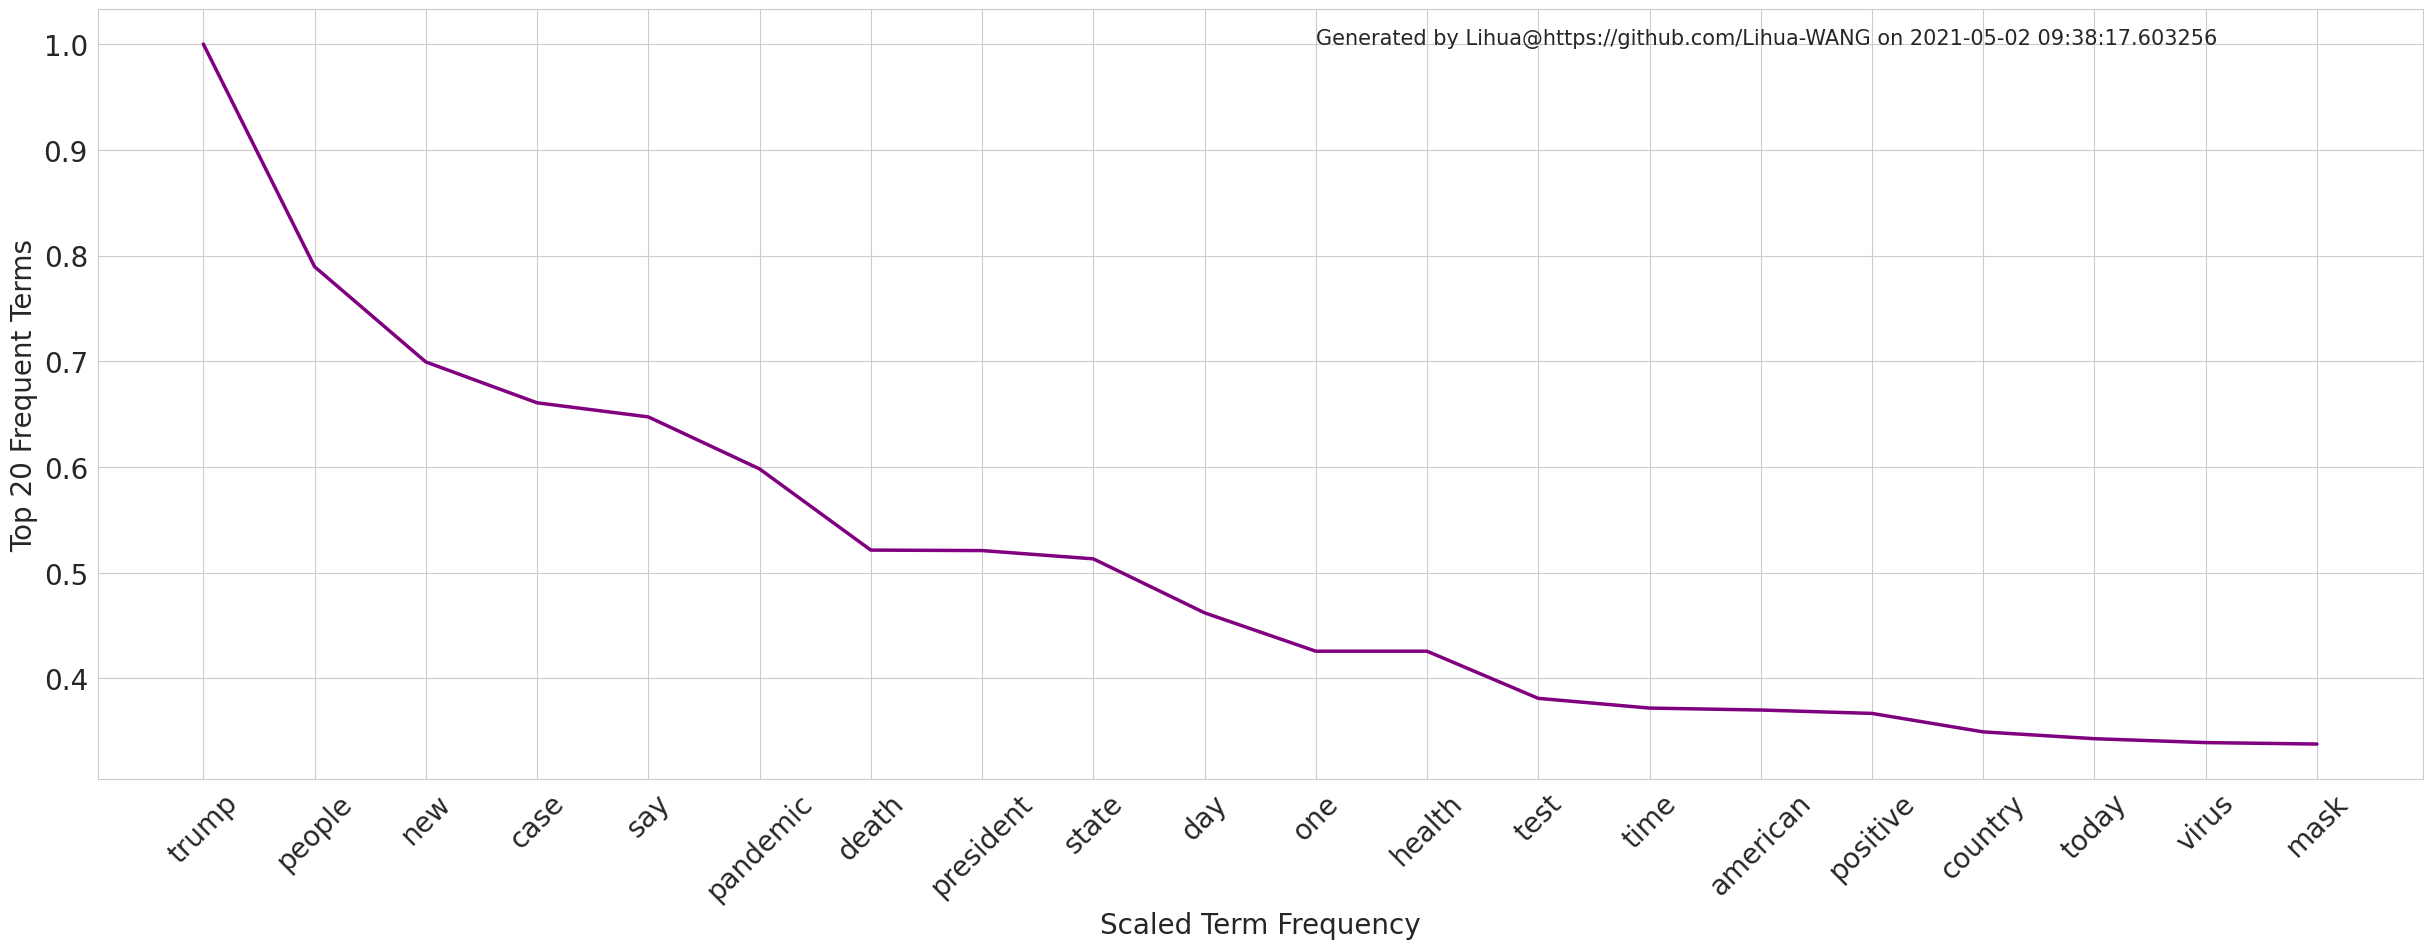

In [ ]:
# non_rumour
uni_non_rumour_tf_df = pd.DataFrame(get_term_frquency_scaled(sorted_uni_non_rumour).items())
uni_non_rumour_tf_df = uni_non_rumour_tf_df[:20]
uni_non_rumour_tf_df.columns = ['term', 'scaled_freq']
uni_non_rumour_tf_df.set_index('term', inplace=True)
dict_term_freq = {}
dict_term_freq['Ind_1'] = uni_non_rumour_tf_df
uni_non_rumour_tf_df['original_freq'] = list(sorted_uni_non_rumour.values())[:20]
display(uni_non_rumour_tf_df)

# wordcloud
sorted_dict_term_count = get_term_frquency_scaled(sorted_uni_non_rumour)
custom_text = "Generated by Lihua@https://github.com/Lihua-WANG on " + str(datetime.datetime.now())
generate_word_cloud('/content/drive/My Drive/data/red_yellow_mask3.jpg', sorted_dict_term_count, 550, 1100, 40, custom_text)
# plot
plot_line_chart(uni_non_rumour_tf_df, uni_non_rumour_tf_df.index, 'scaled_freq')

In [ ]:
from collections import defaultdict
from collections import Counter

def bigram_build(texts):
  bi_gram_text = dict()
  tmp = str()
  for i in range(len(texts)):
    tmp += (texts[i] + " ")
  texts = tmp
  words = tt.tokenize(texts)
  bigram_words = zip(words[:-1], words[1:])
  for bigram in bigram_words:
    try:
      bi_gram_text[bigram] += 1
    except:
      bi_gram_text[bigram] = 1
  bi_gram_text = dict(sorted(bi_gram_text.items(), key = lambda kv:(kv[1], kv[0]), reverse = True))
  return bi_gram_text

sorted_bi_rumour = bigram_build(rumour_source)
sorted_bi_non_rumour = bigram_build(non_rumour_source)

NameError: ignored

In [ ]:
# bi-rumour
bi_rumour_tf_df = pd.DataFrame(get_term_frquency_scaled(sorted_bi_rumour).items())
bi_rumour_tf_df.columns = ['term', 'scaled_freq']
for i in range(len(bi_rumour_tf_df['term'])):
  bi_rumour_tf_df['term'][i] = ' '.join(bi_rumour_tf_df['term'][i])
bi_rumour_tf_df.set_index('term', inplace=True)
dict_term_freq = {}
dict_term_freq['Ind_1'] = bi_rumour_tf_df
bi_rumour_tf_df['original_freq'] = list(sorted_bi_rumour.values())
display(bi_rumour_tf_df.head(20))

# wordcloud
sorted_dict_term_count = bi_rumour_tf_df.groupby('term')['scaled_freq'].apply(lambda x:float(x)).to_dict()
custom_text = "Generated by Lihua@https://github.com/Lihua-WANG on " + str(datetime.datetime.now())
generate_word_cloud('/content/drive/My Drive/data/red_yellow_mask3.jpg', sorted_dict_term_count, 550, 1100, 40, custom_text)
# plot
plot_line_chart(bi_rumour_tf_df.head(20), bi_rumour_tf_df.head(20).index, 'scaled_freq')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
bi_non_rumour_tf_df = pd.DataFrame(get_term_frquency_scaled(sorted_bi_non_rumour).items())
bi_non_rumour_tf_df.columns = ['term', 'scaled_freq']
for i in range(len(bi_non_rumour_tf_df['term'])):
  bi_non_rumour_tf_df['term'][i] = ' '.join(bi_non_rumour_tf_df['term'][i])
bi_non_rumour_tf_df.set_index('term', inplace=True)
dict_term_freq = {}
dict_term_freq['Ind_1'] = bi_non_rumour_tf_df
bi_non_rumour_tf_df['original_freq'] = list(sorted_bi_non_rumour.values())
display(bi_non_rumour_tf_df.head(20))

# # wordcloud
# sorted_dict_term_count = bi_non_rumour_tf_df.groupby('term')['scaled_freq'].apply(lambda x:float(x)).to_dict()
# custom_text = "Generated by Lihua@https://github.com/Lihua-WANG on " + str(datetime.datetime.now())
# generate_word_cloud('/content/drive/My Drive/data/red_yellow_mask3.jpg', sorted_dict_term_count, 550, 1100, 40, custom_text)
# # plot
# plot_line_chart(bi_non_rumour_tf_df.head(20), bi_non_rumour_tf_df.index.head(20), 'scaled_freq')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


scaled_freq  original_freq
term                                            
president trump       1.000000     426          
tested positive       0.910798     388          
white house           0.725352     309          
new case              0.591549     252          
social distancing     0.546948     233          
new york              0.509390     217          
public health         0.446009     190          
wear mask             0.420188     179          
donald trump          0.415493     177          
united state          0.394366     168          
test positive         0.366197     156          
task force            0.326291     139          
trump administration  0.284038     121          
stay home             0.272300     116          
trump say             0.246479     105          
week ago              0.237089     101          
wearing mask          0.230047     98           
nursing home          0.227700     97           
world health          0.213615     91           
joe biden             0.213615     91

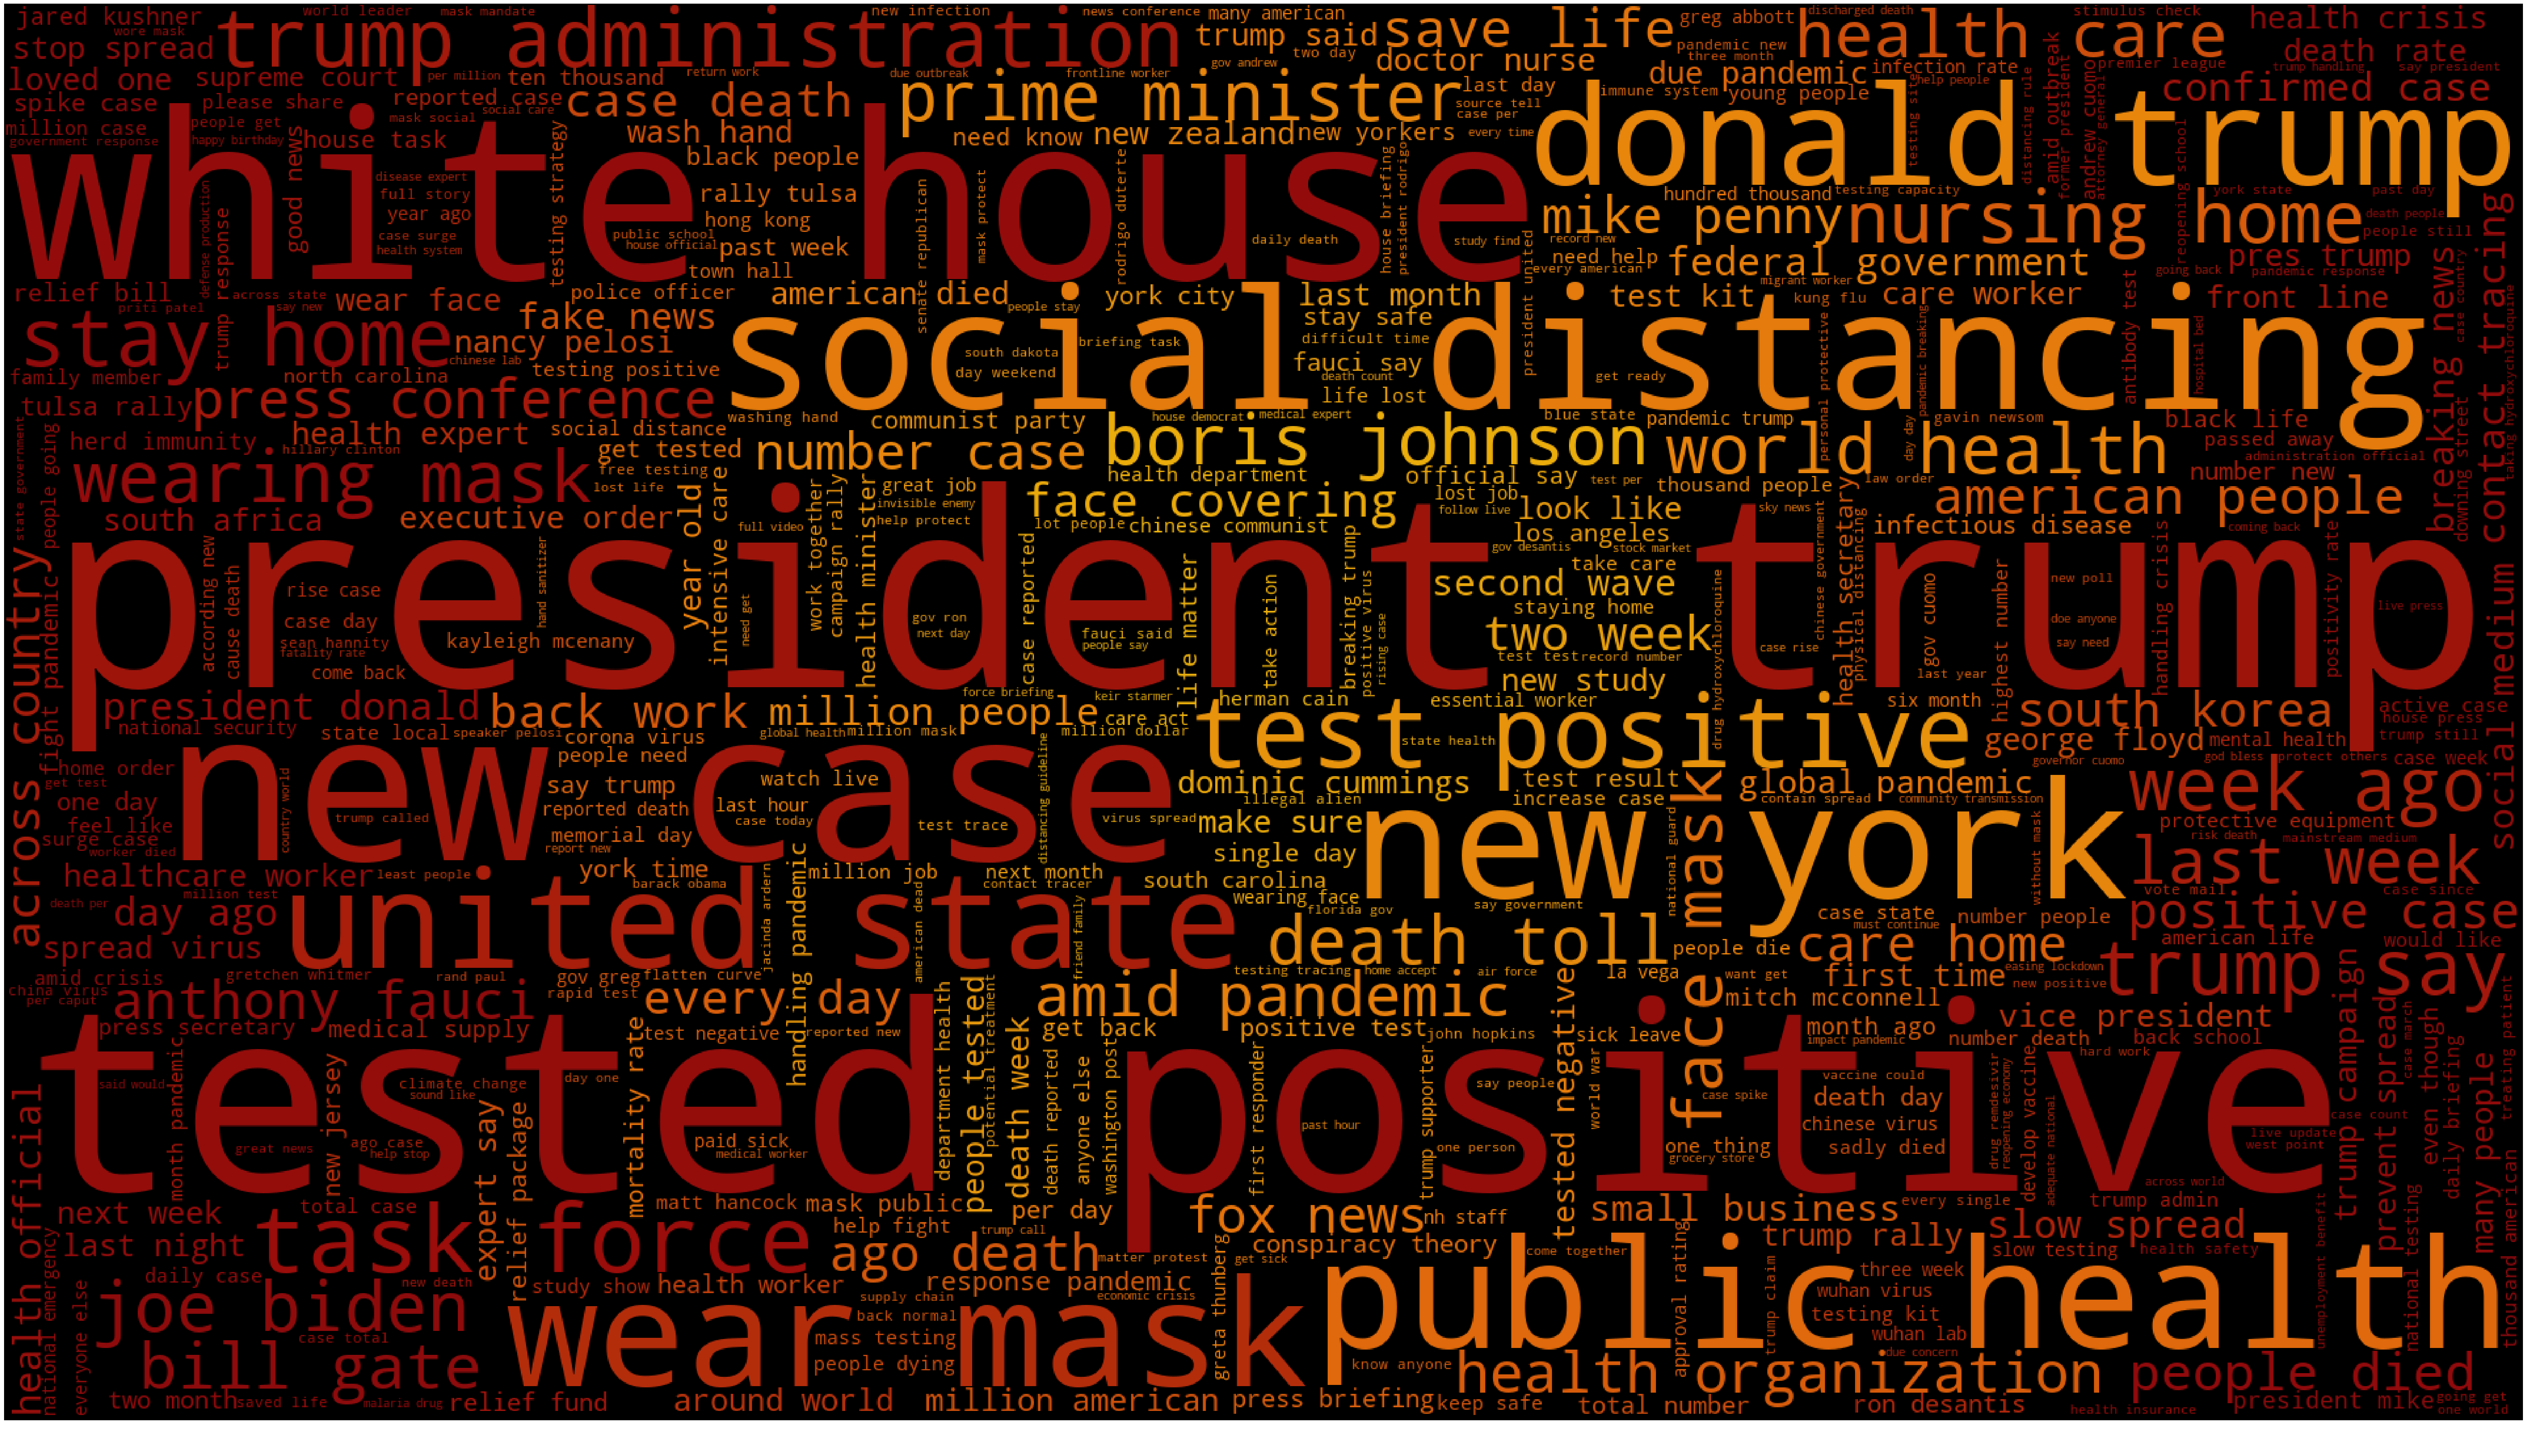

In [ ]:
sorted_dict_term_count = bi_non_rumour_tf_df.groupby('term')['scaled_freq'].apply(lambda x:float(x)).to_dict()
custom_text = "Generated by Lihua@https://github.com/Lihua-WANG on " + str(datetime.datetime.now())
generate_word_cloud('/content/drive/My Drive/data/red_yellow_mask3.jpg', sorted_dict_term_count, 550, 1100, 40, custom_text)


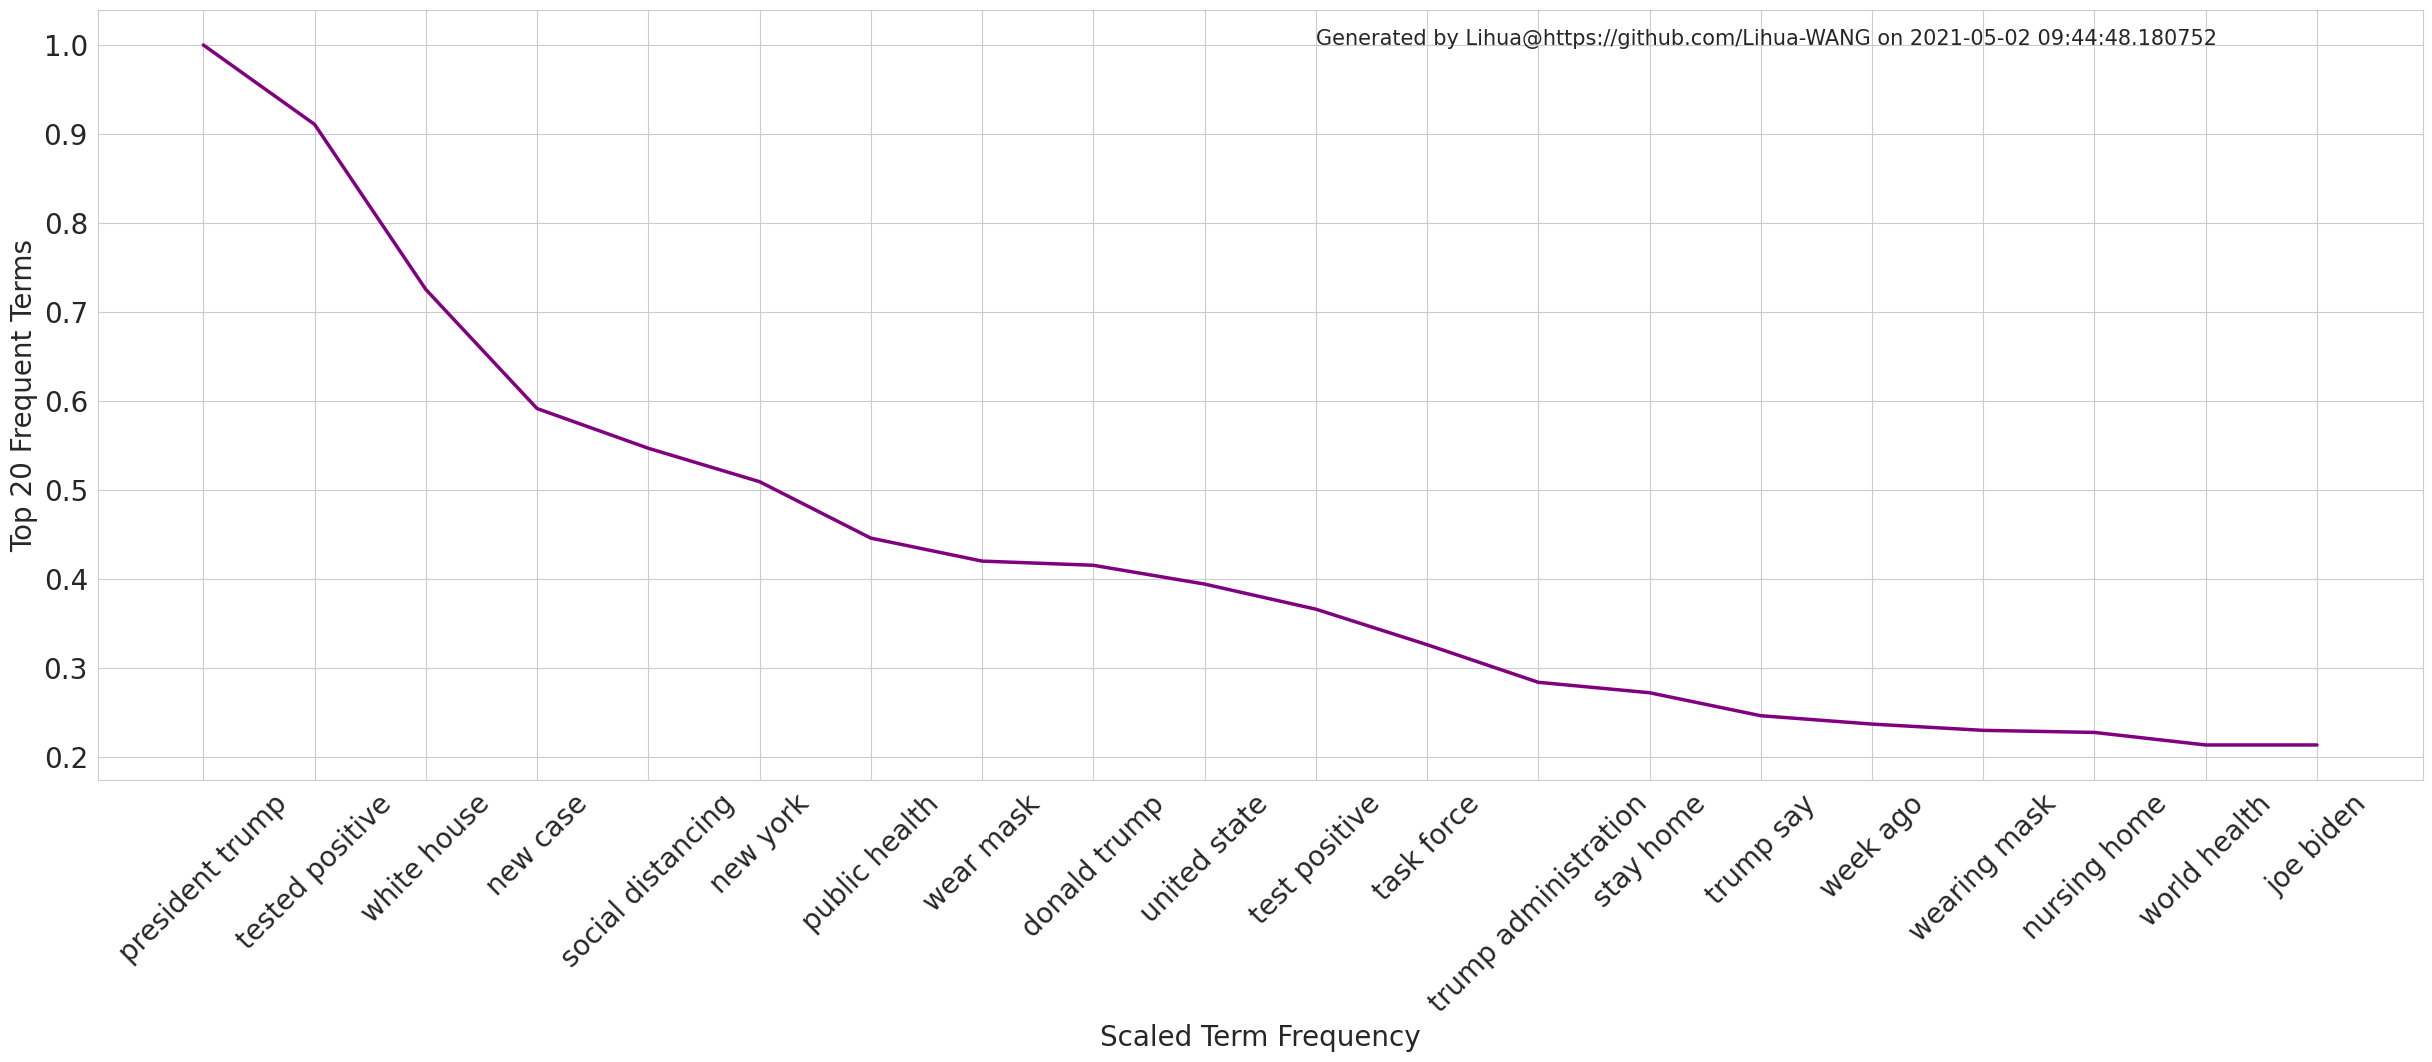

In [ ]:
plot_line_chart(bi_non_rumour_tf_df.head(20), bi_non_rumour_tf_df.head(20).index, 'scaled_freq')

In [ ]:
# with open('/content/drive/My Drive/data/covid.data.jsonl', 'r') as f:
#     for line in f:
#       tweet = json.loads(line)
# tweet[9]

In [ ]:
"""
hashtags analyse
"""
covid_word = {"#covid19", "#Covid19", "#Covid-19", "#COVID19", "#COVID", "#Covid_19", "#COVID-19", "#coronavirus", "#Coronavirus", "#CoronaVirus"}

def get_all_hashtags(data):
    data = [i for p in data for i in p]
    data = " ".join(data)
    data = tt.tokenize(data)
    # data = re.sub(r'((#covid[^\s]+)|(#Covid[^\s]+)|(#coronavirus[^\s]+)|(#Corona[^\s]+))', '#COVID-19', data)
    # data = [word for word in data if nltk.re.match(r".*[a-z]+.*", word)]
    # data = [word for word in data if word in covid_word]
    for i in range(len(data)):
      if data[i] in covid_word:
        data[i] = ""
    hashtags = []
    for word in data:
        if word.startswith("#") and len(word) > 1:
            hashtags.append(word)
    hashtag_dict = {}
    for singlematch in hashtags:
      if singlematch not in hashtag_dict.keys():
          hashtag_dict[singlematch] = 1
      else:
          hashtag_dict[singlematch] = hashtag_dict[singlematch]+1
    hashtag_ordered_list = sorted(hashtag_dict.items(), key=lambda x:x[1])
    hashtag_ordered_list = hashtag_ordered_list[::-1]

    return hashtag_ordered_list

rumour_hashtags_dict = get_all_hashtags(df_rumour["total_text"])
non_rumour_hashtags_dict = get_all_hashtags(df_non_rumour["total_text"])


In [ ]:
# rumour_hashtags_dict

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


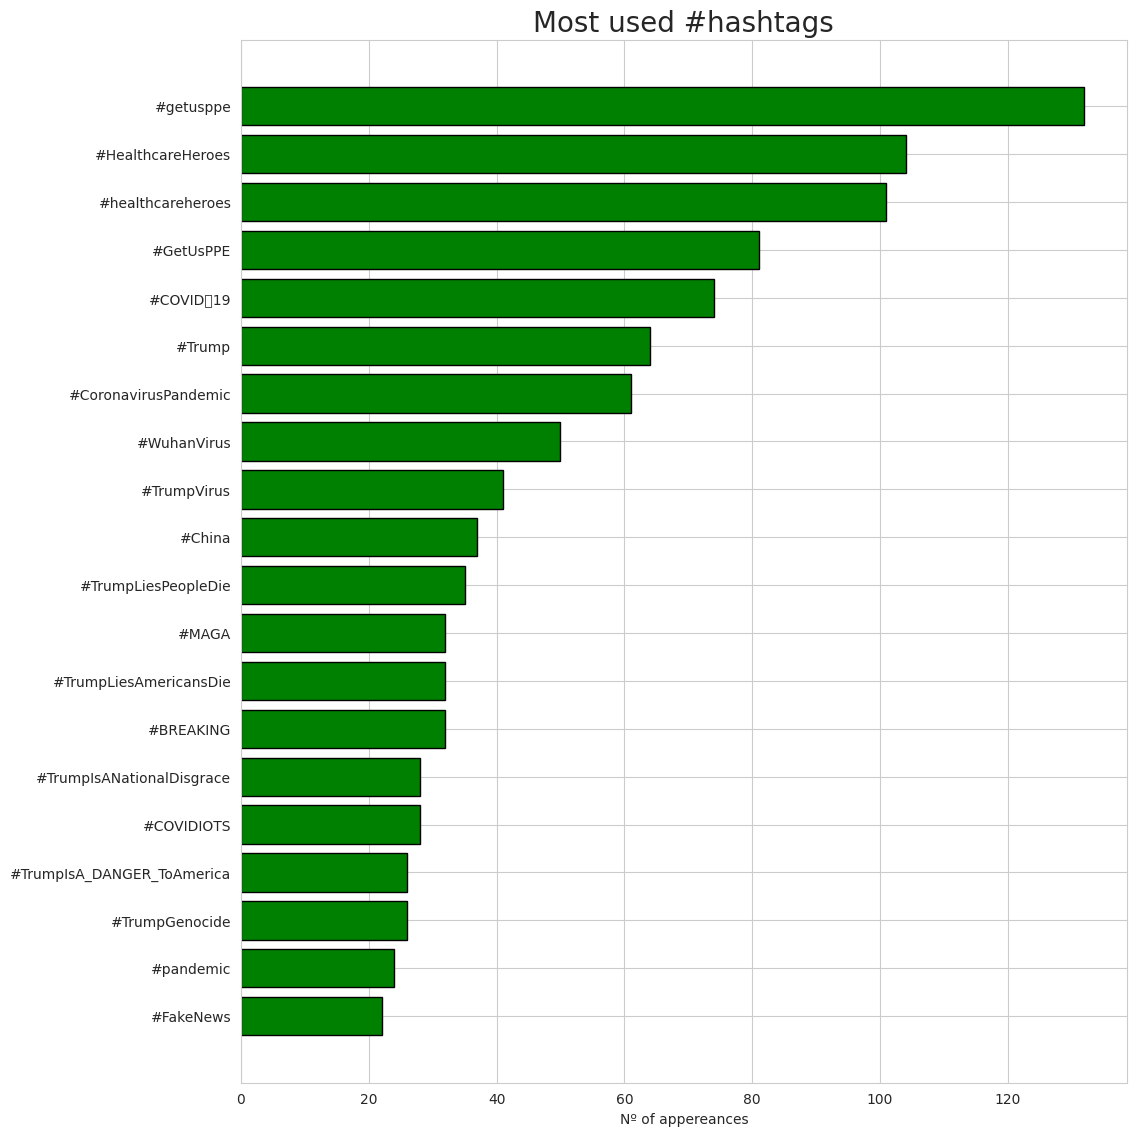

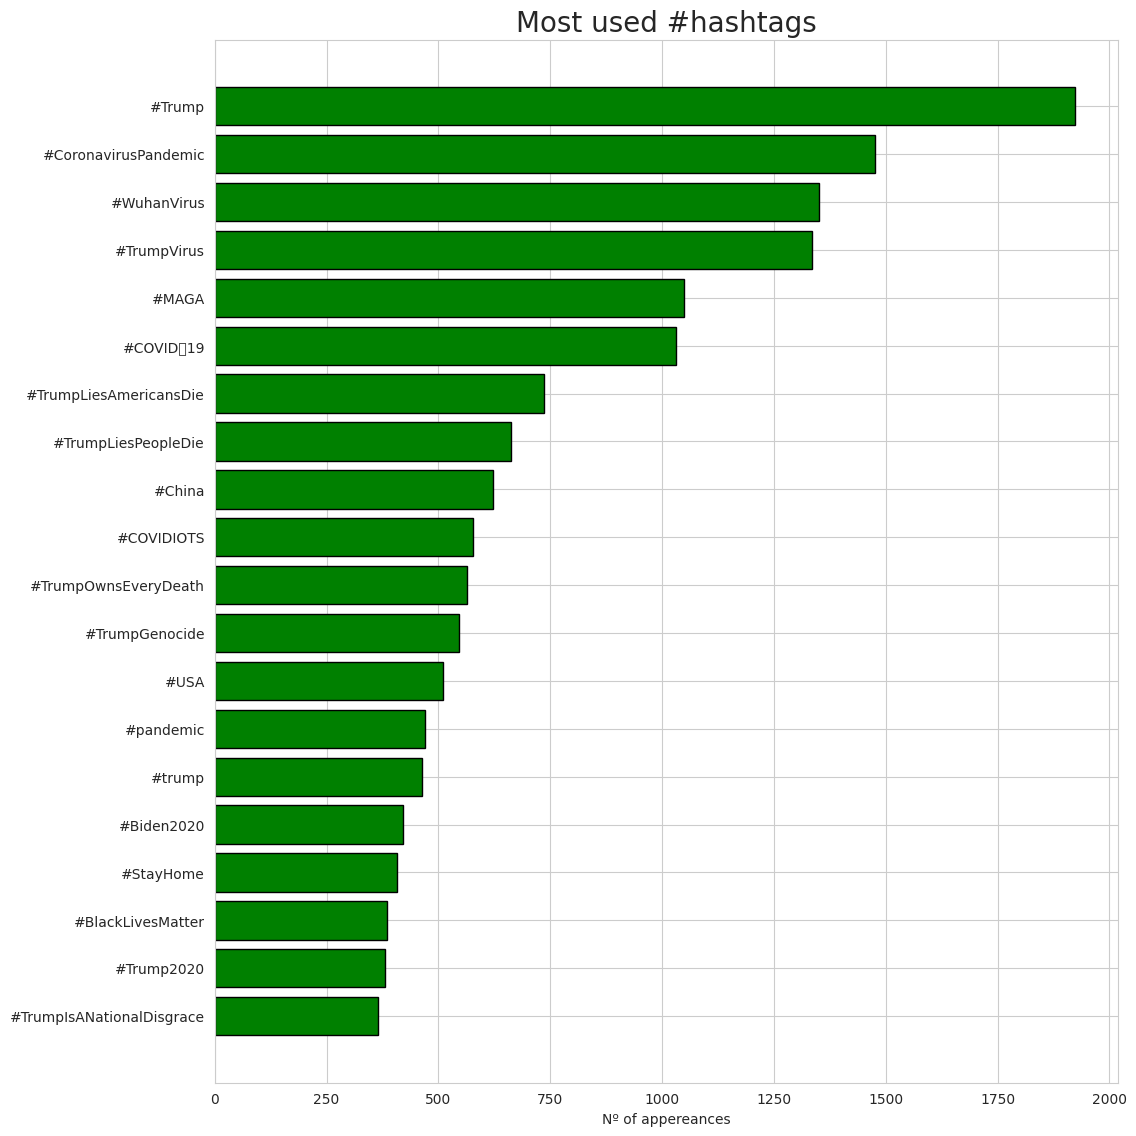

In [ ]:
#Separating the hashtags and their values into two different lists
def plot_hashtags(hash_dict):
  hashtag_ordered_values = []
  hashtag_ordered_keys = []
  #Pick the 20 most used hashtags to plot
  for item in hash_dict[0:20]:
      hashtag_ordered_keys.append(item[0])
      hashtag_ordered_values.append(item[1])

  #Plotting a graph with the most used hashtags
  fig, ax = plt.subplots(figsize = (12,12))
  y_pos = np.arange(len(hashtag_ordered_keys))
  ax.barh(y_pos ,list(hashtag_ordered_values)[::-1], align='center', color = 'green', edgecolor = 'black', linewidth=1)
  ax.set_yticks(y_pos)
  ax.set_yticklabels(list(hashtag_ordered_keys)[::-1])
  ax.set_xlabel("Nº of appereances")
  ax.set_title("Most used #hashtags", fontsize = 20)
  plt.tight_layout(pad=3)
  plt.show()

plot_hashtags(rumour_hashtags_dict)
plot_hashtags(non_rumour_hashtags_dict)

In [ ]:
"""
mentioned users in tweets analyse
"""

def get_all_mention_tags(data):
    data = [i for p in data for i in p]
    data = " ".join(data)
    data = tt.tokenize(data)
    # for i in range(len(data)):
    #   if data[i] == "@realDonaldTrump":
    #     data[i] = ""
    menstiontags = []
    for word in data:
        if word.startswith("@") and len(word) > 1:
            menstiontags.append(word)
    menstiontags_dict = {}
    for singlematch in menstiontags:
      if singlematch not in menstiontags_dict.keys():
          menstiontags_dict[singlematch] = 1
      else:
          menstiontags_dict[singlematch] = menstiontags_dict[singlematch] + 1
    menstiontags_ordered_list = sorted(menstiontags_dict.items(), key=lambda x:x[1])
    menstiontags_ordered_list = menstiontags_ordered_list[::-1]

    return menstiontags_ordered_list

rumour_mentiontags_dict = get_all_mention_tags(df_rumour["total_text"])
non_rumour_mentiontags_dict = get_all_mention_tags(df_non_rumour["total_text"])

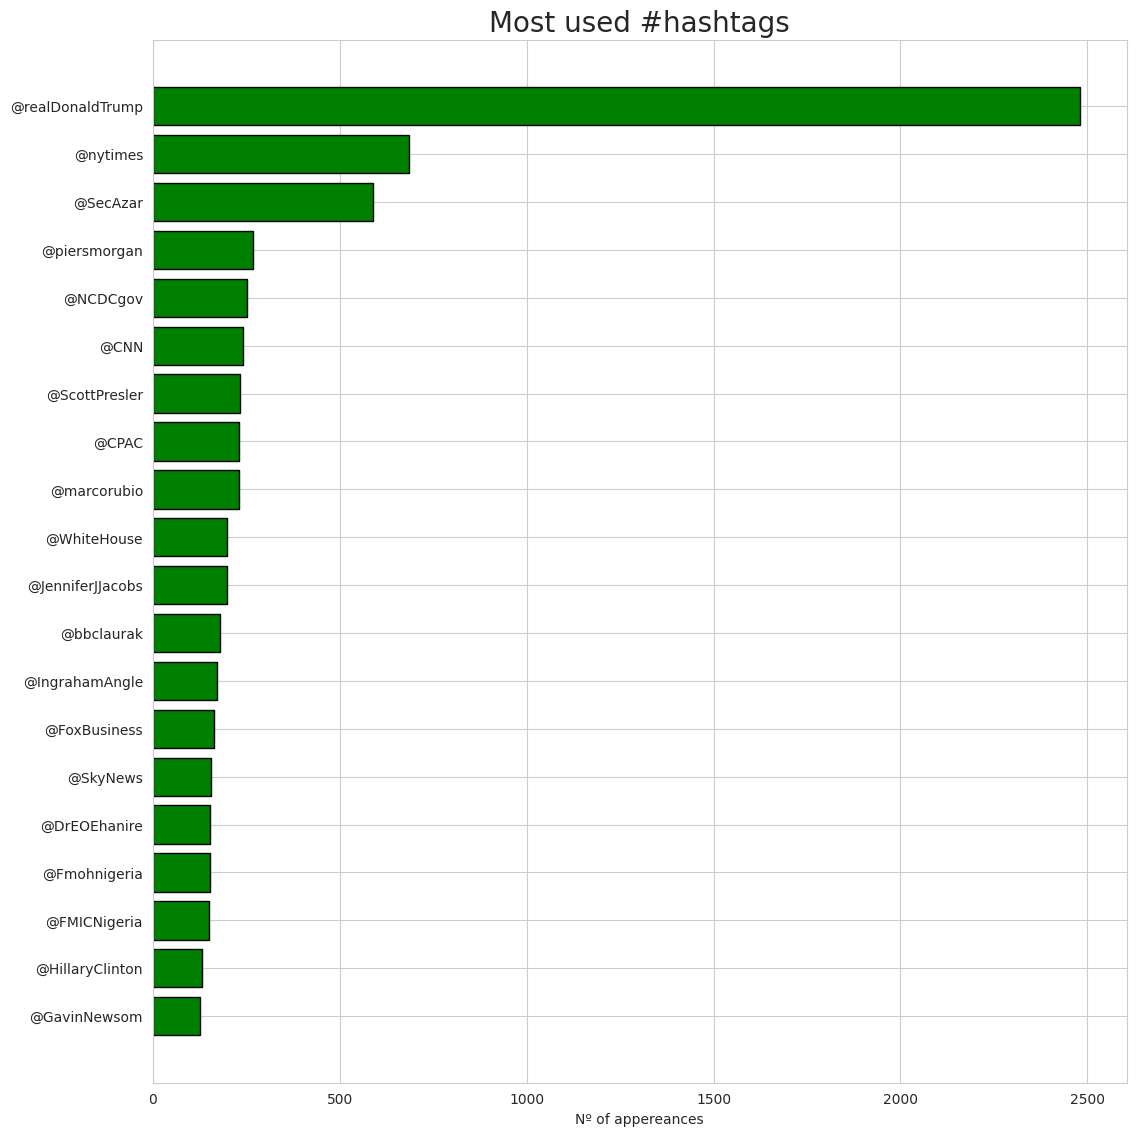

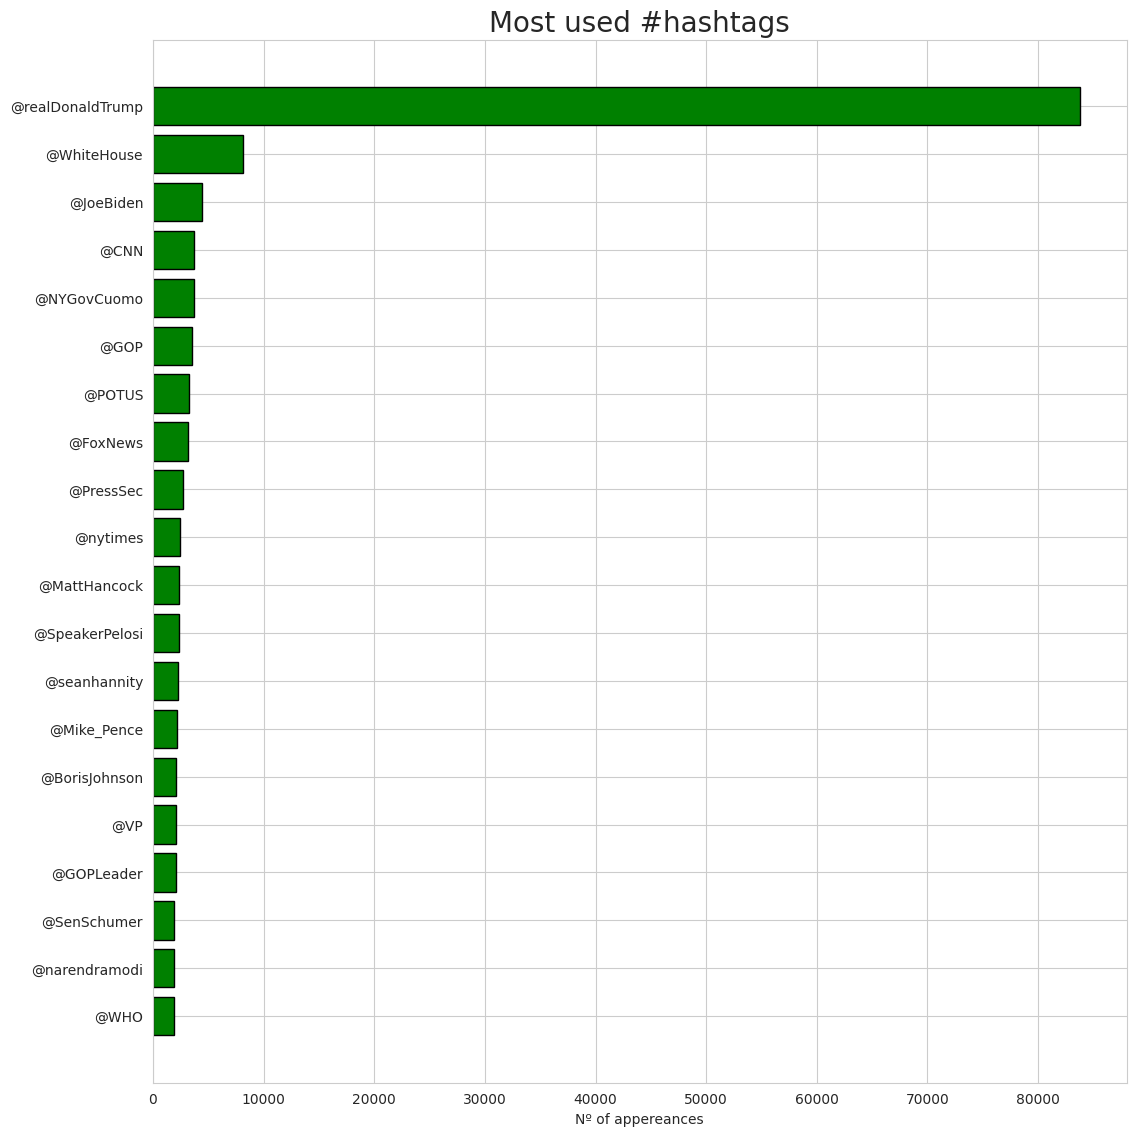

In [ ]:
plot_hashtags(rumour_mentiontags_dict)
plot_hashtags(non_rumour_mentiontags_dict)

In [ ]:
# df_covid

In [ ]:
"""
TOPIC CHANGE OVER TIME
"""
def bi_freq_month(df_month, month):
  sorted_bi = bigram_build(df_month.source_text.tolist())
  bi_tf_df = pd.DataFrame(get_term_frquency_scaled(sorted_bi).items())
  bi_tf_df.columns = ['term', 'scaled_freq']
  for i in range(len(bi_tf_df['term'])):
    bi_tf_df['term'][i] = ' '.join(bi_tf_df['term'][i])
  print(month)
  print(bi_tf_df.head(10))
  print()

# RUMOUR
df_rumour_month = pd.DataFrame(df_rumour[["time", "source_text"]])
df_rumour_month = df_rumour_month.sort_values(by = 'time')
df_rumour_month.reset_index(inplace=True)
del df_rumour_month['index']
df_rumour_month = df_rumour_month.set_index('time')

df_rumour_month1 = df_rumour_month['2020-1-1':'2020-1-31'].reset_index()
bi_freq_month(df_rumour_month1, "2020-1-1 - 2020-1-31")
df_rumour_month2 = df_rumour_month['2020-2-1':'2020-2-29'].reset_index()
bi_freq_month(df_rumour_month2, "2020-2-1 - 2020-2-29")
df_rumour_month3 = df_rumour_month['2020-3-1':'2020-3-31'].reset_index()
bi_freq_month(df_rumour_month3, "2020-3-1 - 2020-3-31")
df_rumour_month4 = df_rumour_month['2020-4-1':'2020-4-30'].reset_index()
bi_freq_month(df_rumour_month4, "2020-4-1 - 2020-4-30")
df_rumour_month5 = df_rumour_month['2020-5-1':'2020-5-31'].reset_index()
bi_freq_month(df_rumour_month5, "2020-5-1 - 2020-5-31")
df_rumour_month6 = df_rumour_month['2020-6-1':'2020-6-30'].reset_index()
bi_freq_month(df_rumour_month6, "2020-6-1 - 2020-6-30")
df_rumour_month7 = df_rumour_month['2020-7-1':'2020-8-31'].reset_index()
bi_freq_month(df_rumour_month7, "2020-7-1 - 2020-8-31")

# NON-RUMOUR
df_non_rumour_month = pd.DataFrame(df_non_rumour[["time", "source_text"]])
df_non_rumour_month = df_non_rumour_month.sort_values(by = 'time')
df_non_rumour_month.reset_index(inplace=True)
del df_non_rumour_month['index']
df_non_rumour_month = df_non_rumour_month.set_index('time')

df_non_rumour_month1 = df_non_rumour_month['2020-1-1':'2020-1-31'].reset_index()
bi_freq_month(df_non_rumour_month1, "2020-1-1 - 2020-1-31")
df_non_rumour_month2 = df_non_rumour_month['2020-2-1':'2020-2-29'].reset_index()
bi_freq_month(df_non_rumour_month2, "2020-2-1 - 2020-2-29")
df_non_rumour_month3 = df_non_rumour_month['2020-3-1':'2020-3-31'].reset_index()
bi_freq_month(df_non_rumour_month3, "2020-3-1 - 2020-3-31")
df_non_rumour_month4 = df_non_rumour_month['2020-4-1':'2020-4-30'].reset_index()
bi_freq_month(df_non_rumour_month4, "2020-4-1 - 2020-4-30")
df_non_rumour_month5 = df_non_rumour_month['2020-5-1':'2020-5-31'].reset_index()
bi_freq_month(df_non_rumour_month5, "2020-5-1 - 2020-5-31")
df_non_rumour_month6 = df_non_rumour_month['2020-6-1':'2020-6-30'].reset_index()
bi_freq_month(df_non_rumour_month6, "2020-6-1 - 2020-6-30")
df_non_rumour_month7 = df_non_rumour_month['2020-7-1':'2020-8-31'].reset_index()
bi_freq_month(df_non_rumour_month7, "2020-7-1 - 2020-8-31")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-1-1 - 2020-1-31
                     term  scaled_freq
0  confirmed case          1.00       
1  yannick ferreira        0.25       
2  wuhan epicentre         0.25       
3  wuhan central           0.25       
4  working closely         0.25       
5  went effect             0.25       
6  unidentified pneumonia  0.25       
7  type breaking           0.25       
8  two case                0.25       
9  trump say               0.25       

2020-2-1 - 2020-2-29
              term  scaled_freq
0  get flu          1.0        
1  flu shot         1.0        
2  year see         0.5        
3  year people      0.5        
4  work get         0.5        
5  went doctor      0.5        
6  week way         0.5        
7  way much         0.5        
8  washington say   0.5        
9  virologist told  0.5        

2020-3-1 - 2020-3-31
              term  scaled_freq
0  confirmed case   1.000000   
1  new case         0.666667   
2  report new       0.375000   
3  total case       0.2916

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-4-1 - 2020-4-30
               term  scaled_freq
0  death toll        1.000000   
1  new case          0.967742   
2  confirmed case    0.806452   
3  total number      0.516129   
4  case reported     0.516129   
5  new york          0.483871   
6  case death        0.451613   
7  reported nigeria  0.322581   
8  reported death    0.322581   
9  people died       0.322581   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-5-1 - 2020-5-31
               term  scaled_freq
0  new case          1.000000   
1  confirmed case    0.754098   
2  death toll        0.475410   
3  total number      0.459016   
4  tested positive   0.327869   
5  report new        0.229508   
6  nursing home      0.213115   
7  number confirmed  0.213115   
8  truck driver      0.196721   
9  new york          0.196721   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-6-1 - 2020-6-30
              term  scaled_freq
0  new case         1.000000   
1  confirmed case   0.500000   
2  report new       0.271429   
3  new death        0.242857   
4  case death       0.214286   
5  tested positive  0.200000   
6  total confirmed  0.142857   
7  death toll       0.142857   
8  single day       0.128571   
9  june june        0.128571   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-7-1 - 2020-8-31
              term  scaled_freq
0  new case         1.000      
1  confirmed case   0.325      
2  report new       0.275      
3  reported new     0.250      
4  since pandemic   0.200      
5  record new       0.175      
6  pandemic began   0.175      
7  tested positive  0.150      
8  new death        0.150      
9  case today       0.150      

2020-1-1 - 2020-1-31
                term  scaled_freq
0  case reported      1.0        
1  zero deadly        0.5        
2  yes frightening    0.5        
3  year would         0.5        
4  year celebration   0.5        
5  wuhan interesting  0.5        
6  wuhan ground       0.5        
7  wuhan china        0.5        
8  wrote piece        0.5        
9  would never        0.5        



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-2-1 - 2020-2-29
                   term  scaled_freq
0  trump administration  1.0        
1  mike penny            0.9        
2  president trump       0.8        
3  white house           0.6        
4  south carolina        0.6        
5  public health         0.6        
6  united state          0.5        
7  washing hand          0.4        
8  vice president        0.3        
9  trump put             0.3        



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-3-1 - 2020-3-31
                term  scaled_freq
0  president trump    1.000000   
1  tested positive    0.929577   
2  white house        0.647887   
3  public health      0.492958   
4  new york           0.450704   
5  test positive      0.436620   
6  stay home          0.380282   
7  social distancing  0.366197   
8  united state       0.323944   
9  health care        0.295775   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-4-1 - 2020-4-30
                term  scaled_freq
0  president trump    1.000000   
1  white house        0.744361   
2  tested positive    0.571429   
3  new york           0.518797   
4  week ago           0.503759   
5  social distancing  0.443609   
6  donald trump       0.398496   
7  task force         0.368421   
8  united state       0.360902   
9  stay home          0.353383   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-5-1 - 2020-5-31
                term  scaled_freq
0  president trump    1.000000   
1  tested positive    0.704348   
2  white house        0.660870   
3  social distancing  0.565217   
4  nursing home       0.495652   
5  new case           0.391304   
6  new york           0.356522   
7  trump say          0.347826   
8  donald trump       0.347826   
9  wear mask          0.304348   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-6-1 - 2020-6-30
                term  scaled_freq
0  new case           1.000000   
1  tested positive    0.776860   
2  wear mask          0.710744   
3  president trump    0.504132   
4  social distancing  0.479339   
5  new york           0.413223   
6  public health      0.404959   
7  white house        0.396694   
8  wearing mask       0.314050   
9  test positive      0.314050   



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


2020-7-1 - 2020-8-31
                term  scaled_freq
0  tested positive    1.000000   
1  wear mask          0.685714   
2  president trump    0.542857   
3  new case           0.514286   
4  donald trump       0.514286   
5  white house        0.485714   
6  test positive      0.414286   
7  public health      0.385714   
8  social distancing  0.357143   
9  new york           0.342857   



In [ ]:
"""
emotion analyse
"""
emoji_file = pd.read_csv('/content/drive/My Drive/data/source(1).csv')
emoji_unicode_file = pd.read_csv('/content/drive/My Drive/data/emoji_unicode.csv')

In [ ]:
emoji_unicode = []
def double_to_backslant(str):
  res = eval(repr(str).replace('\\\\', '\\'))
  return res
for i in range(64):
  emoji_unicode.append(double_to_backslant(emoji_unicode_file['0'][i]))

In [ ]:
rumour_emoji = []
non_rumour_emoji = []
for i in range(len(df_covid.label)):
  if df_covid.label[i]:
    rumour_emoji.append(emoji_file['Emoji_2'][i])
    rumour_emoji.append(emoji_file['Emoji_3'][i])
    rumour_emoji.append(emoji_file['Emoji_4'][i])
  else:
    non_rumour_emoji.append(emoji_file['Emoji_2'][i])
    non_rumour_emoji.append(emoji_file['Emoji_3'][i])
    non_rumour_emoji.append(emoji_file['Emoji_4'][i])

In [ ]:
rumour_emoji_count = {}
non_rumour_emoji_count = {}
for i in range(64):
  rumour_emoji_count[emoji_unicode[i]] = rumour_emoji.count(i) / len(rumour_emoji)
  non_rumour_emoji_count[emoji_unicode[i]] = non_rumour_emoji.count(i) / len(non_rumour_emoji)
rumour_emoji_count = sorted(rumour_emoji_count.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
non_rumour_emoji_count = sorted(non_rumour_emoji_count.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)

In [ ]:
rumour_emoji_count[:10]

[('👍', 0.09077568134171908),
 ('😠', 0.08846960167714885),
 ('😡', 0.059958071278826),
 ('👏', 0.048846960167714885),
 ('💪', 0.040880503144654086),
 ('😕', 0.03920335429769392),
 ('👊', 0.0350104821802935),
 ('😢', 0.0310272536687631),
 ('😄', 0.030607966457023062),
 ('😐', 0.027672955974842768)]

In [ ]:
non_rumour_emoji_count[:10]

[('😠', 0.08885807915301235),
 ('👍', 0.08690446180993194),
 ('😡', 0.05986891857827074),
 ('👏', 0.046844802957734646),
 ('💪', 0.041152004033274514),
 ('😕', 0.037769935299554656),
 ('👊', 0.03172002352743467),
 ('😄', 0.03148895050836064),
 ('😢', 0.03079573145113856),
 ('😷', 0.02674145029829426)]

In [ ]:
x1 = []
x2 = []
y1 = []
y2 = []

for i in zip(rumour_emoji_count[:5], non_rumour_emoji_count[:5]):
  x1.append(i[0][0])
  x2.append(i[1][0])
  y1.append(int(i[0][1] * 100))
  y2.append(int(i[1][1] * 100))
x1.append('other')
x2.append('other')
y1.append(100 - sum(y1))
y2.append(100 - sum(y2))

([<matplotlib.patches.Wedge at 0x7f2c39697d90>,
 [Text(1.056323050796661, 0.3068902285111644, '👍'),
  Text(0.7530018030078657, 0.8018655028537539, '😠'),
  Text(0.37261169821920803, 1.0349688509081798, '😡'),
  Text(0.06906955709217592, 1.097829402176445, '👏'),
  Text(-0.20611945413751356, 1.080515974257694, '💪'),
  Text(-0.6465638066837908, -0.8899186726249572, 'other')])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128170 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128170 missing from current font.
  font.se

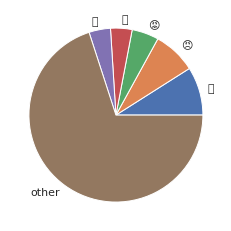

In [ ]:
plt.pie(y1, labels=x1)

([<matplotlib.patches.Wedge at 0x7f2c3968b190>,
 [Text(1.0654414787782402, 0.27355886989611045, '😠'),
  Text(0.8018655028537539, 0.7530018030078657, '👍'),
  Text(0.43686270001984967, 1.0095300794584414, '😡'),
  Text(0.13786657939974728, 1.0913261686061657, '👏'),
  Text(-0.13786652831108198, 1.0913261750601648, '💪'),
  Text(-0.6741978428372162, -0.8691704485966171, 'other')])

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128077 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128079 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 128170 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 128170 missing from current font.
  font.se

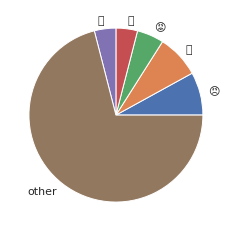

In [ ]:
plt.pie(y2, labels=x2)

In [ ]:
"""
senti analyse
"""
# Rumour
df_rumour.loc[:,'senti'].value_counts()
neg_rumour = df_rumour.loc[:,'senti'].value_counts()[0] / len(df_rumour)
pos_rumour = df_rumour.loc[:,'senti'].value_counts()[1] / len(df_rumour)
print("Negtive sentimate tweets in rumour account for ", neg_rumour)
print("Positive sentimate in rumour account for ", pos_rumour)

# # Non-rumour
df_non_rumour.loc[:,'senti'].value_counts()
neg_non_rumour = df_non_rumour.loc[:,'senti'].value_counts()[0] / len(df_non_rumour)
pos_non_rumour = df_non_rumour.loc[:,'senti'].value_counts()[1] / len(df_non_rumour)
print("Negtive sentimate tweets in non_rumour account for ", neg_non_rumour)
print("Positive sentimate in non_rumour account for ", pos_non_rumour)

Negtive sentimate tweets in rumour account for  0.6861635220125786
Positive sentimate in rumour account for  0.31383647798742137
Negtive sentimate tweets in non_rumour account for  0.6213133350138644
Positive sentimate in non_rumour account for  0.3786866649861356


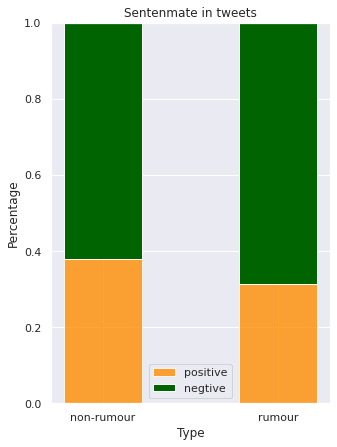

In [ ]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize = (5,7))

label_list = ['non-rumour', 'rumour']
num_list1 = [pos_non_rumour, pos_rumour]
num_list2 = [neg_non_rumour, neg_rumour]
x = range(len(num_list1))
rects1 = plt.bar(x, height=num_list1, width=0.45, alpha=0.8, color='darkorange', label="positive")
rects2 = plt.bar(x, height=num_list2, width=0.45, color='darkgreen', label="negtive", bottom=num_list1)

plt.ylim(0, 1)
plt.ylabel("Percentage")
plt.xticks(x, label_list)
plt.xlabel("Type")
plt.title("Sentenmate in tweets")
plt.legend()
plt.show()
